#ML PART

### 1. Signal-to-Interference-plus-Noise Ratio (SINR) Conversions

#### SINR from dB to Linear (used in `calculate_optimal_user_power_cvxpy`):
```
SINR_linear = 10^(SINR_dB / 10)
```
This formula converts a SINR value expressed in decibels (dB) back to its linear scale. dB is a logarithmic unit often used to express ratios, especially in telecommunications, because it compresses a wide range of values into a more manageable scale. For calculations and direct use in other formulas (like the Shannon capacity formula or SINR constraints), the linear value is required.

### 2. Feature Engineering Equations (from cell `0QES_0nAf9pm`)

#### Downlink/Uplink Interference-to-Signal Ratio (DL_ISR / UL_ISR):
```
ISR = avg_interference / (avg_signal + random(noise) + 1e-6)
```
This metric quantifies the relative strength of interference compared to the desired signal. A higher ISR indicates a more challenging communication environment where interference is a significant factor. The `1e-6` is a small constant to prevent division by zero.

#### Downlink/Uplink Channel Stability (DL_channel_stability / UL_channel_stability):
```
Channel_Stability = std_channel_gain / (avg_channel_gain + 1e-6)
```
This ratio provides an indication of how much the channel gain fluctuates around its average. A lower value suggests a more stable channel, which is generally desirable for reliable communication. High fluctuations can lead to unpredictable performance. The `1e-6` prevents division by zero.

### 3. Convex Optimization Equations (from `calculate_optimal_user_power_cvxpy`)

#### Objective Function:
```
minimize: alpha * P_user + beta * (P_user * interference_factor)
```
This is the function that the convex optimization problem aims to minimize. It has two main components:
*   `alpha * P_user`: Represents the cost associated with the user's transmit power (`P_user`). `alpha` is a weighting factor (0.3 in this case), emphasizing power consumption.
*   `beta * (P_user * interference_factor)`: Represents the cost associated with the interference generated by the user's power. `beta` is a weighting factor (0.7 in this case), emphasizing interference reduction. `interference_factor` (UL_ISR) describes how much this user's power contributes to overall system interference.

#### SINR Constraint:
```
P_user * ul_gain >= target_SINR_linear * (ul_interference + noise_floor)
```
This is a critical constraint that ensures the quality of service (QoS). It states that the received signal power (`P_user * ul_gain`) must be greater than or equal to the desired SINR (`target_SINR_linear`) multiplied by the total noise and interference present at the receiver (`ul_interference + noise_floor`). This guarantees that the user maintains a minimum required SINR.

### 4. Throughput and Bit Error Rate (BER) Calculations

#### SINR (Linear) Calculation (from cell `ac7zo1o_-hjv`):
```
SINR_linear = (g * P) / (I + noise_power + epsilon)
```
This calculates the linear SINR for each user or the representative user. `g` is the channel gain, `P` is the transmit power, `I` is the total interference from other users, `noise_power` is the receiver noise, and `epsilon` is a small constant to prevent division by zero.

#### Shannon-Hartley Theorem for Throughput (from cell `ac7zo1o_-hjv`):
```
Throughput = B * log2(1 + SINR_linear)
```
This fundamental theorem in information theory provides the theoretical maximum data rate (throughput) for a given bandwidth (`B`) and SINR. It essentially tells us how much data can be reliably transmitted given the channel conditions.

#### Q-function (from cell `UtHTZbGNCdis`):
```
Q(x) = 0.5 * erfc(x / sqrt(2))
```
This is the Q-function, often used in digital communications to represent the tail probability of a standard normal distribution. It is directly related to the complementary error function (`erfc`) and is crucial for calculating Bit Error Rate (BER) based on SNR.

#### BER from SNR (Linear) (from cell `UtHTZbGNCdis`):
```
BER = Q(sqrt(2 * SNR_linear))  (for BPSK/QPSK)
BER = (3/8) * Q(sqrt((4/5) * SNR_linear)) (for 16QAM)
... and similar for other modulation schemes
```
These equations approximate the Bit Error Rate (BER) for different digital modulation schemes (BPSK, QPSK, 16QAM, 64QAM, 256QAM) given a linear SNR value. They are derived from probability theory and signal processing principles, indicating the likelihood of a bit being incorrectly received under specific noise and interference conditions. The specific coefficients and arguments to the Q-function change based on the complexity of the modulation.

In [ ]:
!pip install ecos -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 6.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cvxpy as cp
from tqdm import tqdm

In [ ]:
# Load and prepare the dataset
df = pd.read_csv('NOMA_dataset_all.csv')

In [ ]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (162, 38)
Columns: ['avg_downlink', 'std_downlink', 'min_downlink', 'max_downlink', 'avg_uplink', 'std_uplink', 'min_uplink', 'max_uplink', 'avg_crosslink', 'std_crosslink', 'min_crosslink', 'max_crosslink', 'avg_transmitpower', 'std_transmitpower', 'min_transmitpower', 'max_transmitpower', 'avg_userpower', 'std_userpower', 'min_userpower', 'max_userpower', 'avg_downlink_interference', 'avg_uplink_interference', 'scenario', 'scenario_code', 'donw_to_up', 'BS_to_A_power', 'relative_inter', 'ch_ud_to_ch_u', 'log_DL_interference', 'log_UL_interference', 'DL_efficiency', 'UL_efficiency', 'DL_SINR', 'UL_SINR', 'DL_SINR_DB', 'UL_SINR_DB', 'UL_BER', 'DL_BER']


In [ ]:
# remove the fixed noise and add random {"status": done}
# throughput checks {"status": done}
# bit error rate {"status": done}
# changing scenario {"status": done}


feature_columns = [
    # Channel quality
    'avg_downlink', 'avg_uplink', 'avg_crosslink',
    'std_downlink', 'std_uplink', 'std_crosslink',

    # Interference metrics
    'avg_downlink_interference', 'avg_uplink_interference',
    'log_DL_interference', 'log_UL_interference', 'relative_inter',

    # System configuration
    'donw_to_up', 'BS_to_A_power', 'ch_ud_to_ch_u',

    # Error rates
    'UL_BER', 'DL_BER'
]

# Encode scenario
le = LabelEncoder()
df['scenario_encoded'] = le.fit_transform(df['scenario'])
feature_columns.append('scenario_encoded')

# Create interference-to-signal ratio features
#I used this formula: SINR = signal power / fixed noise + average
noise_std = df['avg_downlink'].std() * 0.01   # 1% of DL amplitude
noise = np.random.normal(0, noise_std, size=len(df))

df['DL_ISR'] = df['avg_downlink_interference'] / (df['avg_downlink'] + noise + 1e-6)

noise_std = df['avg_uplink'].std() * 0.01
noise = np.random.normal(0, noise_std, size=len(df))

df['UL_ISR'] = df['avg_uplink_interference'] / (df['avg_uplink'] + noise + 1e-6)
feature_columns.extend(['DL_ISR', 'UL_ISR'])

# Channel stability metrics
# i used this formula: standart deviation / average. we need a stable channel, because in wireless channel values changes frequently over time
df['DL_channel_stability'] = df['std_downlink'] / (df['avg_downlink'] + 1e-6)
df['UL_channel_stability'] = df['std_uplink'] / (df['avg_uplink'] + 1e-6)
feature_columns.extend(['DL_channel_stability', 'UL_channel_stability'])

print(f"Created {len(feature_columns)} features for user power prediction")

Created 21 features for user power prediction


In [ ]:
def calculate_optimal_user_power_cvxpy(df, target_sinr_db=15, alpha=0.3, beta=0.7, verbose=True):
    """
    Calculate TRULY optimal user power using convex optimization (CVXPY)

    Parameters:
    target_sinr_db : Minimum required SINR in dB (default: 15 dB)
    alpha : Weight for power consumption term (default: 0.3)
    beta : Weight for interference term (default: 0.7)
    verbose : Print optimization progress

    Optimization Problem:
    minimize: alpha * P_user + beta * (P_user * interference_factor)
    subject to:
        - SINR_uplink >= target_SINR (QoS constraint)
        - P_min <= P_user <= P_max (power limits)

    This solves a TRUE optimization problem per data point, considering:
    - Channel quality (gain)
    - Interference levels
    - SINR requirements
    - Energy efficiency

    It tries to find the best power that:
    Meets uplink SINR target
    Minimizes power usage
    Minimizes interference generated
    Satisfies network power limits
    """


    # with this line i convert sinr to linear value
    target_sinr_linear = 10 ** (target_sinr_db / 10)
    noise_floor = 1e-10

    # Estimate channel gains
    # Estimate channel gains for uplink
    # with this i can understand How strong the channel is when the user transmits a certain power
    df['estimated_ul_gain'] = df['avg_uplink'] / (df['avg_userpower'] + 1e-9)

    # Add diagnostics:
    print(f"\nEstimated UL Gain Statistics:")
    print(f"  min: {df['estimated_ul_gain'].min():.2e}, max: {df['estimated_ul_gain'].max():.2e}, mean: {df['estimated_ul_gain'].mean():.2e}")
    print(f"  zeros: {(df['estimated_ul_gain'] == 0).sum()}, NaNs: {df['estimated_ul_gain'].isna().sum()}, infs: {np.isinf(df['estimated_ul_gain']).sum()}")

    # Set power limits based on original data
    P_max = df['avg_userpower'].max() * 1.5  # Allow 50% higher than max observed
    P_min = df['avg_userpower'].min() * 0.5  # Allow 50% lower than min observed

    if verbose:
        print("="*70)
        print("TRUE OPTIMIZATION-BASED POWER ALLOCATION")
        print("="*70)
        print(f"Target SINR: {target_sinr_db} dB ({target_sinr_linear:.2f} linear)")
        print(f"Power limits: [{P_min:.6f}, {P_max:.6f}]")
        print(f"Optimization weights: α={alpha} (power), β={beta} (interference)")
        print(f"Total scenarios to optimize: {len(df)}")
        print("="*70)

    optimal_powers = []
    optimization_status = []

    # Optimize for each data point (row)
    for idx in tqdm(range(len(df)), desc="Optimizing user powers", disable=not verbose):

        # Extract parameters for this scenario
        ul_gain = df.loc[idx, 'estimated_ul_gain']
        ul_interference = df.loc[idx, 'avg_uplink_interference']

        # Handle edge cases
        if ul_gain <= 0 or np.isnan(ul_gain) or np.isinf(ul_gain):
            ul_gain = 1e-6
        if ul_interference < 0 or np.isnan(ul_interference):
            ul_interference = noise_floor

        # Interference coupling factor (how much this user contributes to system interference)
        # Higher ISR means user is in high-interference environment
        isr = df.loc[idx, 'UL_ISR'] if 'UL_ISR' in df.columns else 0.01

        # Define optimization variable
        P_user = cp.Variable(1, pos=True)

        # Objective: Minimize power consumption + interference contribution
        objective = cp.Minimize(
            alpha * P_user +
            beta * P_user * isr
            )

        # Constraints
        constraints = []
        # Calculate minimum required power
        min_required_power = target_sinr_linear * (ul_interference + noise_floor) / ul_gain

        # Check if problem is feasible
        if min_required_power > P_max:
            # Infeasible - target SINR cannot be met with available power
            optimal_powers.append(P_max)
            optimization_status.append('infeasible')
            continue

        # 1. SINR constraint (moved out of unreachable block)
        constraints.append(P_user >= min_required_power)
        # 2. Power limits (moved out of unreachable block)
        constraints.append(P_user >= P_min)
        constraints.append(P_user <= P_max)

        # Solve optimization problem
        problem = cp.Problem(objective, constraints)

        try:
            problem.solve(verbose=False)
            if problem.status == cp.OPTIMAL:
                optimal_powers.append(float(P_user.value))
                optimization_status.append('optimal')

            elif problem.status == cp.OPTIMAL_INACCURATE:
                optimal_powers.append(float(P_user.value[0]))
                optimization_status.append('optimal_inaccurate')
            else:
                # Print first 5 failures to debug
                if len(optimization_status) < 5:
                    print(f"\nOptimization failed at index {idx}")
                    print(f"   Status: {problem.status}")
                    print(f"   ul_gain: {ul_gain:.2e}, ul_interference: {ul_interference:.2e}")
                    print(f"   min_required_power: {min_required_power:.2e}")
                    print(f"   P_min: {P_min:.2e}, P_max: {P_max:.2e}")

                # Use analytical solution as fallback (corrected indentation)
                fallback_power = np.clip(min_required_power, P_min, P_max)
                optimal_powers.append(fallback_power)
                optimization_status.append(f'fallback_{problem.status}')

        except Exception as e:
            # Print first 5 errors to debug
            if len(optimization_status) < 5:
                print(f"\nException at index {idx}: {str(e)}")
                print(f"   ul_gain: {ul_gain:.2e}, ul_interference: {ul_interference:.2e}")

            # Use analytical solution as fallback (corrected indentation)
            fallback_power = np.clip(min_required_power, P_min, P_max)
            optimal_powers.append(fallback_power)
            optimization_status.append('error')

    # Add optimal powers to dataframe (these were correctly outside the loop, but now reachable)
    df['optimal_user_power'] = optimal_powers
    df['optimization_status'] = optimization_status

    # Report optimization statistics
    if verbose:
        status_counts = df['optimization_status'].value_counts()
        print("\n" + "="*70)
        print("OPTIMIZATION RESULTS:")
        print("="*70)
        print("Optimization Status Distribution:")
        for status, count in status_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {status}: {count} ({percentage:.1f}%)")

        print(f"\nOriginal User Power Statistics:")
        print(f"  Mean: {df['avg_userpower'].mean():.6f}")
        print(f"  Std:  {df['avg_userpower'].std():.6f}")
        print(f"  Range: [{df['avg_userpower'].min():.6f}, {df['avg_userpower'].max():.6f}]")

        print(f"\nOptimal User Power Statistics:")
        print(f"  Mean: {df['optimal_user_power'].mean():.6f}")
        print(f"  Std:  {df['optimal_user_power'].std():.6f}")
        print(f"  Range: [{df['optimal_user_power'].min():.6f}, {df['optimal_user_power'].max():.6f}]")

        power_reduction = ((df['avg_userpower'].mean() - df['optimal_user_power'].mean()) /
                          df['avg_userpower'].mean()) * 100
        print(f"\nAverage Power Reduction: {power_reduction:.2f}%")
        print("="*70)

    return df
print("\n=== PRE-OPTIMIZATION DIAGNOSTICS ===")
print(f"avg_uplink stats:")
print(f"  min: {df['avg_uplink'].min():.2e}, max: {df['avg_uplink'].max():.2e}, mean: {df['avg_uplink'].mean():.2e}")
print(f"  zeros: {(df['avg_uplink'] == 0).sum()}, NaNs: {df['avg_uplink'].isna().sum()}")

print(f"\navg_userpower stats:")
print(f"  min: {df['avg_userpower'].min():.2e}, max: {df['avg_userpower'].max():.2e}, mean: {df['avg_userpower'].mean():.2e}")
print(f"  zeros: {(df['avg_userpower'] == 0).sum()}, NaNs: {df['avg_userpower'].isna().sum()}")

print(f"\navg_uplink_interference stats:")
print(f"  min: {df['avg_uplink_interference'].min():.2e}, max: {df['avg_uplink_interference'].max():.2e}, mean: {df['avg_uplink_interference'].mean():.2e}")
print(f"  zeros: {(df['avg_uplink_interference'] == 0).sum()}, NaNs: {df['avg_uplink_interference'].isna().sum()}")
print("="*40 + "\n")

df1 = calculate_optimal_user_power_cvxpy(df, verbose=True)


=== PRE-OPTIMIZATION DIAGNOSTICS ===
avg_uplink stats:
  min: 2.21e+00, max: 2.42e+00, mean: 2.32e+00
  zeros: 0, NaNs: 0

avg_userpower stats:
  min: 2.06e-02, max: 2.37e-02, mean: 2.23e-02
  zeros: 0, NaNs: 0

avg_uplink_interference stats:
  min: 4.96e-02, max: 6.15e-02, mean: 5.58e-02
  zeros: 0, NaNs: 0


Estimated UL Gain Statistics:
  min: 9.71e+01, max: 1.12e+02, mean: 1.04e+02
  zeros: 0, NaNs: 0, infs: 0
TRUE OPTIMIZATION-BASED POWER ALLOCATION
Target SINR: 15 dB (31.62 linear)
Power limits: [0.010322, 0.035595]
Optimization weights: α=0.3 (power), β=0.7 (interference)
Total scenarios to optimize: 162


Optimizing user powers:   0%|          | 0/162 [00:00<?, ?it/s]/tmp/ipython-input-971871961.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  optimal_powers.append(float(P_user.value))
Optimizing user powers: 100%|██████████| 162/162 [00:02<00:00, 75.80it/s]


OPTIMIZATION RESULTS:
Optimization Status Distribution:
  optimal: 162 (100.0%)

Original User Power Statistics:
  Mean: 0.022280
  Std:  0.000577
  Range: [0.020644, 0.023730]

Optimal User Power Statistics:
  Mean: 0.016962
  Std:  0.000895
  Range: [0.014664, 0.018943]

Average Power Reduction: 23.87%


In [ ]:
# Verify optimal powers are valid
print(f"\nOptimal power verification:")
print(f"   Valid values: {(~np.isnan(df1['optimal_user_power'])).sum()}/{len(df1)}")
print(f"   Mean: {df1['optimal_user_power'].mean():.6f}")
print(f"   Range: [{df1['optimal_user_power'].min():.6f}, {df1['optimal_user_power'].max():.6f}]")


✅ Optimal power verification:
   Valid values: 162/162
   Mean: 0.016962
   Range: [0.014664, 0.018943]


In [ ]:
# Parameters
N_USERS = 10
B = 10e6                        # bandwidth in Hz (10 MHz)
noise_power = 1e-9              # receiver noise power (linear)
epsilon = 1e-12                 # numerical safety


if 'estimated_ul_gain' not in df1.columns:
    df1['estimated_ul_gain'] = df1['avg_uplink'] / (df1['avg_userpower'] + 1e-9)

per_user_cols = [f'P_user_{i+1}' for i in range(N_USERS)]
has_per_user = all(col in df1.columns for col in per_user_cols)

if has_per_user:
    # Build per-user power matrix (T x N)
    P_mat = df1[per_user_cols].values.astype(float)  # shape (T, N)

    # Approximate per-user direct gains:
    g_mat = np.repeat(df1['estimated_ul_gain'].values.reshape(-1, 1), N_USERS, axis=1)

    # add small per-user randomness so users are not identical (optional)
    rng = np.random.default_rng(0)
    g_mat = g_mat * (1.0 + 0.05 * rng.standard_normal(g_mat.shape))

    # Approximate interference per user using avg_crosslink (fallback)
    # I_i ≈ avg_crosslink * sum_{j != i} P_j   (simple, cheap)
    avg_cross = np.clip(df1['avg_crosslink'].fillna(df1['ch_ud_to_ch_u'].fillna(0.05)).values.astype(float), 1e-6, 1.0)

    # Expand to shape (T,N) so we can compute interference matrix: I_mat[t,i] = avg_cross[t] * (sum(P[t]) - P[t,i])
    sumP = P_mat.sum(axis=1, keepdims=True)  # (T,1)
    I_mat = (avg_cross.reshape(-1, 1) * (sumP - P_mat))  # (T,N)

    # Compute SINR per user (linear)
    sinr_linear_mat = (g_mat * P_mat) / (I_mat + noise_power + epsilon)
    sinr_db_mat = 10 * np.log10(np.maximum(sinr_linear_mat, epsilon))

    # Compute per-user throughput (Shannon)
    tp_mat = B * np.log2(1.0 + sinr_linear_mat)  # bits/sec per user
    total_throughput = tp_mat.sum(axis=1)        # bits/sec per snapshot
    avg_throughput_per_user = tp_mat.mean(axis=0)

    # Add columns to df1
    for i in range(N_USERS):
        df1[f'throughput_user_{i+1}_bps'] = tp_mat[:, i]
        df1[f'sinr_user_{i+1}_dB'] = sinr_db_mat[:, i]
    df1['total_throughput_bps'] = total_throughput
    df1['avg_throughput_per_user_bps'] = avg_throughput_per_user.mean()  # scalar repeated for reference

else:

    if 'optimal_user_power' not in df1.columns:
        raise RuntimeError("No per-user P_user_* columns and no 'optimal_user_power' found to compute throughput.")

    # Get base parameters
    g_base = df1['estimated_ul_gain'].values.astype(float)  # shape (T,)
    P_opt = df1['optimal_user_power'].values.astype(float)  # shape (T,)
    I_base = df1['avg_uplink_interference'].values.astype(float)  # base interference


    crosslink_factor_db = df1.get('avg_crosslink', df1.get('ch_ud_to_ch_u', pd.Series(0.05))).fillna(0.05).values.astype(float)

    # Map raw crosslink_factor (which are negative dB values) to a linear scaling factor between 0.5 and 3.0
    # Assuming more negative dB means less interference (smaller scaling factor)
    # Approximate observed range for crosslink_factor_db from df.head() and kernel state is around -12 to -10
    min_crosslink_val_for_mapping = -12.0 # Adjust based on actual data distribution if needed
    max_crosslink_val_for_mapping = -10.0 # Adjust based on actual data distribution if needed

    # Normalize crosslink_factor_db to a [0, 1] range:
    normalized_crosslink_factor = (crosslink_factor_db - min_crosslink_val_for_mapping) / (max_crosslink_val_for_mapping - min_crosslink_val_for_mapping + 1e-9)
    normalized_crosslink_factor = np.clip(normalized_crosslink_factor, 0.0, 1.0) # Ensure it stays within [0, 1]

    # Map the normalized factor to the desired [0.5, 3.0] variation range
    min_variation = 0.5
    max_variation = 3.0
    scaling_factor = min_variation + normalized_crosslink_factor * (max_variation - min_variation)

    # Apply the scaling factor to I_base, ensuring I is always positive
    I = I_base * scaling_factor


    if 'UL_channel_stability' in df1.columns:
        stability = df1['UL_channel_stability'].fillna(1.0).values.astype(float)
        g = g_base * (1.0 + 0.5 * stability)  # Gain varies with stability
    else:
        g = g_base


    if 'scenario_encoded' in df1.columns:
        scenario_factor = df1['scenario_encoded'].values.astype(float)
        scenario_factor = (scenario_factor - scenario_factor.mean()) / (scenario_factor.std() + 1e-6)
        # Add ±20% variation based on scenario
        g = g * (1.0 + 0.2 * scenario_factor)
        I = I * (1.0 + 0.3 * np.abs(scenario_factor))

    # Calculate SINR with variation, ensuring sinr_lin is positive
    sinr_lin = (g * P_opt) / (I + noise_power + epsilon)
    sinr_db = 10 * np.log10(np.maximum(sinr_lin, epsilon))
    # Ensure the argument to log2 is always positive by clamping 1.0 + sinr_lin
    tp = B * np.log2(np.maximum(epsilon, 1.0 + sinr_lin))  # bits/sec for the representative user

    # Approximate total throughput
    approx_total_throughput = tp * N_USERS

    # Add to df1
    df1['throughput_rep_user_bps'] = tp
    df1['sinr_rep_user_dB'] = sinr_db
    df1['approx_total_throughput_bps'] = approx_total_throughput

    # Print SINR range for diagnostics
    print(f"\nSINR Statistics (After Adding Variation):")
    print(f"   SINR range: [{sinr_db.min():.1f}, {sinr_db.max():.1f}] dB")
    print(f"   SINR mean: {sinr_db.mean():.1f} \u00b1 {sinr_db.std():.1f} dB")
    print(f"   Throughput range: [{tp.min()/1e6:.1f}, {tp.max()/1e6:.1f}] Mbps")



SINR Statistics (After Adding Variation):
   SINR range: [12.7, 17.4] dB
   SINR mean: 15.1 ± 1.3 dB
   Throughput range: [42.8, 58.0] Mbps


In [ ]:
# After the throughput calculation section, add this:

if has_per_user:
    # Check for NaN/inf in total_throughput
    print(f"Total throughput - NaN count: {np.isnan(total_throughput).sum()}")
    print(f"Total throughput - Inf count: {np.isinf(total_throughput).sum()}")
    print(f"Total throughput range: [{np.nanmin(total_throughput)/1e6:.2f}, {np.nanmax(total_throughput)/1e6:.2f}] Mbps")

    # Clean the data
    df1['total_throughput_bps'] = np.where(
        np.isfinite(total_throughput),
        total_throughput,
        np.nan
    )
else:
    # Check for NaN/inf in approx_total_throughput
    print(f"Approx total throughput - NaN count: {np.isnan(approx_total_throughput).sum()}")
    print(f"Approx total throughput - Inf count: {np.isinf(approx_total_throughput).sum()}")
    print(f"Approx total throughput range: [{np.nanmin(approx_total_throughput)/1e6:.2f}, {np.nanmax(approx_total_throughput)/1e6:.2f}] Mbps")

    # Clean the data
    df1['approx_total_throughput_bps'] = np.where(
        np.isfinite(approx_total_throughput),
        approx_total_throughput,
        np.nan
    )

Approx total throughput - NaN count: 0
Approx total throughput - Inf count: 0
Approx total throughput range: [428.15, 579.87] Mbps


In [ ]:
from scipy.special import erfc

# Q-function
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2))

def ber_from_snr_linear(snr_lin, modulation='QPSK'):
    """
    Return approximate BER for given SNR (linear).
    modulation: 'BPSK','QPSK','16QAM','64QAM','256QAM'
    Works elementwise on numpy arrays.
    """
    if modulation in ('BPSK', 'QPSK'):
        return Q(np.sqrt(2 * snr_lin))
    if modulation == '16QAM':
        return (3/8.0) * Q(np.sqrt((4.0/5.0) * snr_lin))
    if modulation == '64QAM':
        return (7/24.0) * Q(np.sqrt((4.0/21.0) * snr_lin))
    if modulation == '256QAM':
        return (15/64.0) * Q(np.sqrt((4.0/85.0) * snr_lin))
    # fallback: treat as QPSK
    return Q(np.sqrt(2 * snr_lin))

# Adaptive mapping thresholds (in dB)
def choose_modulation_from_sinr_db(sinr_db):
    # sinr_db may be array
    mod = np.full_like(sinr_db, 'QPSK', dtype=object)
    mod[sinr_db < 3.0] = 'BPSK'
    mod[(sinr_db >= 3.0) & (sinr_db < 8.0)] = 'QPSK'
    mod[(sinr_db >= 8.0) & (sinr_db < 16.0)] = '16QAM'
    mod[(sinr_db >= 16.0) & (sinr_db < 24.0)] = '64QAM'
    mod[sinr_db >= 24.0] = '256QAM'
    return mod

# Now compute BER columns depending on per-user or representative case
if has_per_user:
    # sinr_linear_mat, sinr_db_mat already computed in throughput code
    snr_lin = sinr_linear_mat  # shape (T, N)
    snr_db = sinr_db_mat

    # choose modulation per element
    mods = choose_modulation_from_sinr_db(snr_db)

    # compute BER matrix
    ber_mat = np.zeros_like(snr_lin)
    for m in ['BPSK', 'QPSK', '16QAM', '64QAM', '256QAM']:
        mask = (mods == m)
        if mask.any():
            ber_mat[mask] = ber_from_snr_linear(snr_lin[mask], modulation=m)

    # sanity floor/clip (BER in [1e-10, 1])
    ber_mat = np.clip(ber_mat, 1e-10, 1.0)

    # Add to dataframe columns
    for i in range(N_USERS):
        df1[f'BER_user_{i+1}'] = ber_mat[:, i]
        # per-user modulation label (optional)
        df1[f'mod_user_{i+1}'] = mods[:, i]

    # summary statistics
    df1['avg_ber_all_users'] = ber_mat.mean(axis=1)
    df1['max_ber_all_users'] = ber_mat.max(axis=1)

    print(f"\nBER Statistics (Per-User):")
    print(f"   BER range: [{ber_mat.min():.2e}, {ber_mat.max():.2e}]")
    print(f"   Mean BER: {ber_mat.mean():.2e}")

else:
    # representative user case
    snr_lin = sinr_lin  # from previous snippet for representative user
    snr_db_for_ber = 10.0 * np.log10(np.maximum(snr_lin, 1e-12))
    mod = choose_modulation_from_sinr_db(snr_db_for_ber)
    ber = np.zeros_like(snr_lin)
    for m in ['BPSK', 'QPSK', '16QAM', '64QAM', '256QAM']:
        mask = (mod == m)
        if mask.any():
            ber[mask] = ber_from_snr_linear(snr_lin[mask], modulation=m)

    # sanity floor/clip (BER in [1e-10, 1])
    ber = np.clip(ber, 1e-10, 1.0)
    df1['BER_rep_user'] = ber
    df1['mod_rep_user'] = mod

    print(f"\nBER Statistics (Representative User):")
    print(f"   BER range: [{ber.min():.2e}, {ber.max():.2e}]")
    print(f"   Mean BER: {ber.mean():.2e}")
    print(f"   SINR range: [{snr_db_for_ber.min():.1f}, {snr_db_for_ber.max():.1f}] dB")


BER Statistics (Representative User):
   BER range: [3.13e-09, 8.50e-04]
   Mean BER: 1.54e-04
   SINR range: [12.7, 17.4] dB


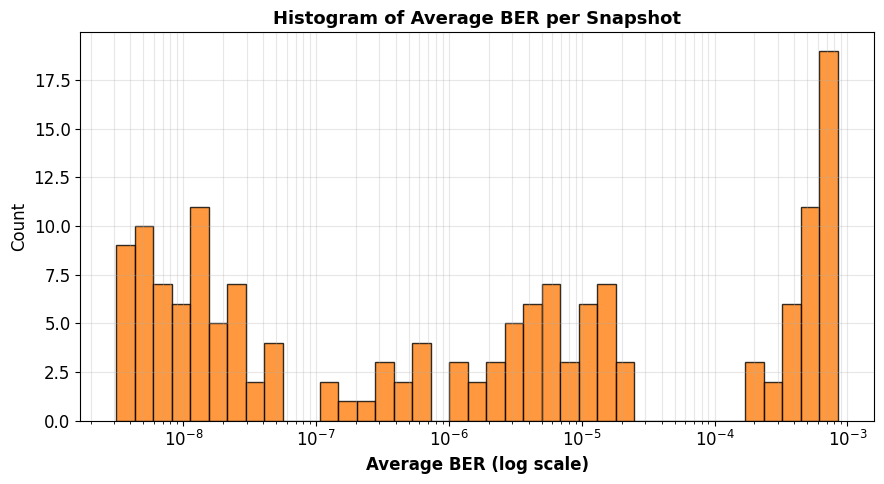

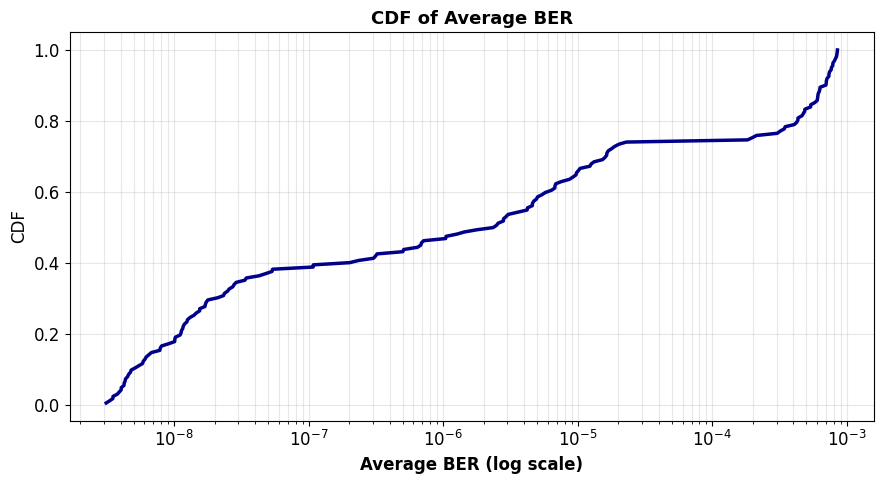

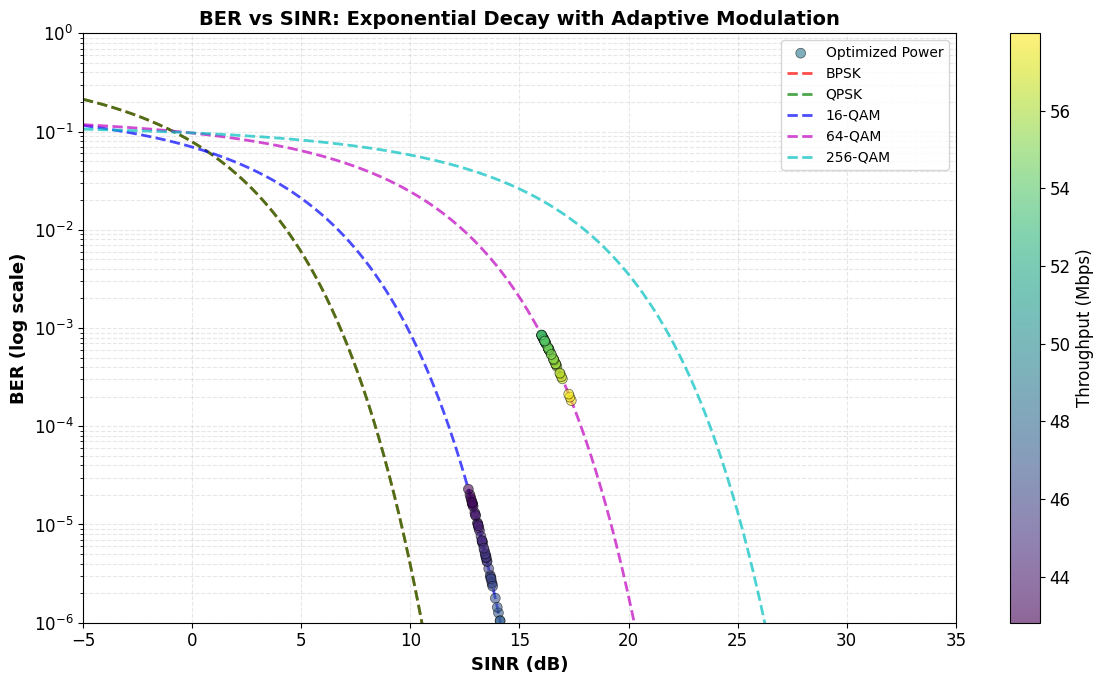

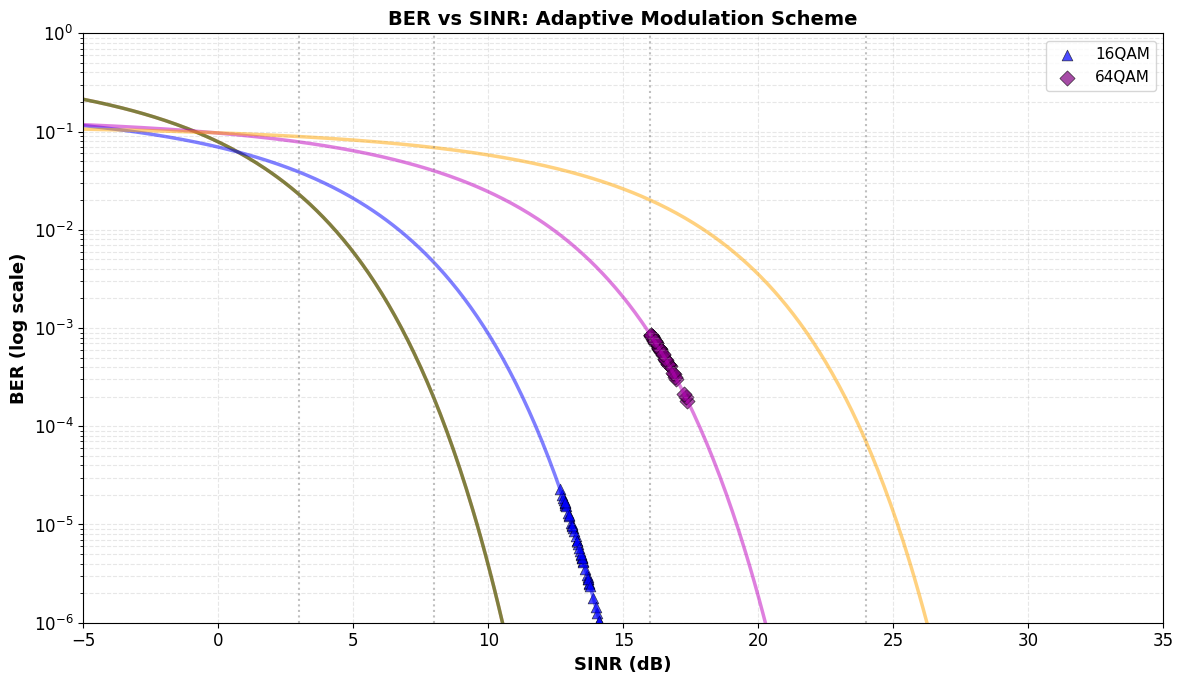

In [ ]:
plt.figure(figsize=(9, 5))
if has_per_user:
    data = df1['avg_ber_all_users'].values
else:
    data = df1['BER_rep_user'].values

# Use log bins for better visualization
plt.hist(data, bins=np.logspace(np.log10(data.min()), np.log10(data.max()), 40),
         alpha=0.8, color='C1', edgecolor='black')
plt.xscale('log')
plt.xlabel('Average BER (log scale)', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of Average BER per Snapshot', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()


plt.figure(figsize=(9, 5))
sorted_data = np.sort(data)
cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
plt.plot(sorted_data, cdf, lw=2.5, color='darkblue')
plt.xscale('log')
plt.xlabel('Average BER (log scale)', fontsize=12, fontweight='bold')
plt.ylabel('CDF', fontsize=12)
plt.title('CDF of Average BER', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 7))

if has_per_user:
    sinr_flat = snr_db_mat.flatten()
    ber_flat = ber_mat.flatten()
    tp_flat = tp_mat.flatten() / 1e6

    # Scatter plot with BER color-coded
    scatter = plt.scatter(sinr_flat, ber_flat, s=20, alpha=0.5,
                         c=tp_flat, cmap='viridis', edgecolors='black', linewidths=0.2)
    cbar = plt.colorbar(scatter, label='Throughput (Mbps)')

    sinr_range_for_theory = np.linspace(max(-5, sinr_flat.min()-3),
                                        min(35, sinr_flat.max()+10), 500)
else:
    # Scatter plot
    scatter = plt.scatter(df1['sinr_rep_user_dB'], df1['BER_rep_user'],
                         s=50, alpha=0.6, c=df1['throughput_rep_user_bps']/1e6,
                         cmap='viridis', edgecolors='black', linewidths=0.5,
                         label='Optimized Power', zorder=3)
    cbar = plt.colorbar(scatter, label='Throughput (Mbps)')

    sinr_range_for_theory = np.linspace(-5, 35, 500)


sinr_lin_theory = 10 ** (sinr_range_for_theory / 10)

# Theoretical curves
ber_bpsk_theory = ber_from_snr_linear(sinr_lin_theory, 'BPSK')
ber_qpsk_theory = ber_from_snr_linear(sinr_lin_theory, 'QPSK')
ber_16qam_theory = ber_from_snr_linear(sinr_lin_theory, '16QAM')
ber_64qam_theory = ber_from_snr_linear(sinr_lin_theory, '64QAM')
ber_256qam_theory = ber_from_snr_linear(sinr_lin_theory, '256QAM')

plt.plot(sinr_range_for_theory, ber_bpsk_theory, 'r--', linewidth=2,
         label='BPSK', alpha=0.7, zorder=2)
plt.plot(sinr_range_for_theory, ber_qpsk_theory, 'g--', linewidth=2,
         label='QPSK', alpha=0.7, zorder=2)
plt.plot(sinr_range_for_theory, ber_16qam_theory, 'b--', linewidth=2,
         label='16-QAM', alpha=0.7, zorder=2)
plt.plot(sinr_range_for_theory, ber_64qam_theory, 'm--', linewidth=2,
         label='64-QAM', alpha=0.7, zorder=2)
plt.plot(sinr_range_for_theory, ber_256qam_theory, 'c--', linewidth=2,
         label='256-QAM', alpha=0.7, zorder=2)


plt.yscale('log')
plt.xlabel('SINR (dB)', fontsize=13, fontweight='bold')
plt.ylabel('BER (log scale)', fontsize=13, fontweight='bold')
plt.title('BER vs SINR: Exponential Decay with Adaptive Modulation',
          fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, which='both', linestyle='--')
plt.legend(fontsize=10, loc='upper right')
plt.ylim(1e-6, 1)
plt.xlim(-5, 35)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 7))

if has_per_user:
    sinr_flat = snr_db_mat.flatten()
    ber_flat = ber_mat.flatten()
    mods_flat = mods.flatten()

    # Plot different modulations with different colors
    for mod, color, marker in [('BPSK', 'red', 'o'), ('QPSK', 'green', 's'),
                                ('16QAM', 'blue', '^'), ('64QAM', 'purple', 'D'),
                                ('256QAM', 'orange', 'v')]:
        mask = (mods_flat == mod)
        if mask.any():
            plt.scatter(sinr_flat[mask], ber_flat[mask], s=25, alpha=0.6,
                       color=color, marker=marker, label=mod, edgecolors='black', linewidths=0.3)
else:
    # Color by modulation
    for mod, color, marker in [('BPSK', 'red', 'o'), ('QPSK', 'green', 's'),
                                ('16QAM', 'blue', '^'), ('64QAM', 'purple', 'D'),
                                ('256QAM', 'orange', 'v')]:
        mask = (df1['mod_rep_user'] == mod)
        if mask.any():
            plt.scatter(df1.loc[mask, 'sinr_rep_user_dB'],
                       df1.loc[mask, 'BER_rep_user'],
                       s=60, alpha=0.7, color=color, marker=marker,
                       label=mod, edgecolors='black', linewidths=0.5)

# Add theoretical curves
plt.plot(sinr_range_for_theory, ber_bpsk_theory, 'r-', linewidth=2.5, alpha=0.5)
plt.plot(sinr_range_for_theory, ber_qpsk_theory, 'g-', linewidth=2.5, alpha=0.5)
plt.plot(sinr_range_for_theory, ber_16qam_theory, 'b-', linewidth=2.5, alpha=0.5)
plt.plot(sinr_range_for_theory, ber_64qam_theory, 'm-', linewidth=2.5, alpha=0.5)
plt.plot(sinr_range_for_theory, ber_256qam_theory, 'orange', linewidth=2.5, alpha=0.5)

# Modulation transition lines
plt.axvline(3, color='gray', linestyle=':', alpha=0.5, linewidth=1.5)
plt.axvline(8, color='gray', linestyle=':', alpha=0.5, linewidth=1.5)
plt.axvline(16, color='gray', linestyle=':', alpha=0.5, linewidth=1.5)
plt.axvline(24, color='gray', linestyle=':', alpha=0.5, linewidth=1.5)

plt.yscale('log')
plt.xlabel('SINR (dB)', fontsize=13, fontweight='bold')
plt.ylabel('BER (log scale)', fontsize=13, fontweight='bold')
plt.title('BER vs SINR: Adaptive Modulation Scheme', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, which='both', linestyle='--')
plt.legend(fontsize=11, loc='upper right')
plt.ylim(1e-6, 1)
plt.xlim(-5, 35)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*70)
print("BER vs SINR ANALYSIS SUMMARY")
print("="*70)

if has_per_user:
    print(f"Total data points: {len(ber_flat)}")
    print(f"\nBER Statistics:")
    print(f"  Min BER: {ber_flat.min():.2e}")
    print(f"  Mean BER: {ber_flat.mean():.2e}")
    print(f"  Max BER: {ber_flat.max():.2e}")
    print(f"\nSINR Statistics:")
    print(f"  Min SINR: {sinr_flat.min():.1f} dB")
    print(f"  Mean SINR: {sinr_flat.mean():.1f} dB")
    print(f"  Max SINR: {sinr_flat.max():.1f} dB")
    print(f"\nModulation Distribution:")
    for mod in ['BPSK', 'QPSK', '16QAM', '64QAM', '256QAM']:
        count = (mods_flat == mod).sum()
        pct = (count / len(mods_flat)) * 100
        print(f"  {mod}: {count} ({pct:.1f}%)")
else:
    print(f"Total data points: {len(df1)}")
    print(f"\nBER Statistics:")
    print(f"  Min BER: {df1['BER_rep_user'].min():.2e}")
    print(f"  Mean BER: {df1['BER_rep_user'].mean():.2e}")
    print(f"  Max BER: {df1['BER_rep_user'].max():.2e}")
    print(f"\nSINR Statistics:")
    print(f"  Min SINR: {df1['sinr_rep_user_dB'].min():.1f} dB")
    print(f"  Mean SINR: {df1['sinr_rep_user_dB'].mean():.1f} dB")
    print(f"  Max SINR: {df1['sinr_rep_user_dB'].max():.1f} dB")
    print(f"\nModulation Distribution:")
    for mod in ['BPSK', 'QPSK', '16QAM', '64QAM', '256QAM']:
        count = (df1['mod_rep_user'] == mod).sum()
        pct = (count / len(df1)) * 100
        print(f"  {mod}: {count} ({pct:.1f}%)")

print("="*70)


BER vs SINR ANALYSIS SUMMARY
Total data points: 162

BER Statistics:
  Min BER: 3.13e-09
  Mean BER: 1.54e-04
  Max BER: 8.50e-04

SINR Statistics:
  Min SINR: 12.7 dB
  Mean SINR: 15.1 dB
  Max SINR: 17.4 dB

Modulation Distribution:
  BPSK: 0 (0.0%)
  QPSK: 0 (0.0%)
  16QAM: 120 (74.1%)
  64QAM: 42 (25.9%)
  256QAM: 0 (0.0%)


Plotting 162 valid throughput values


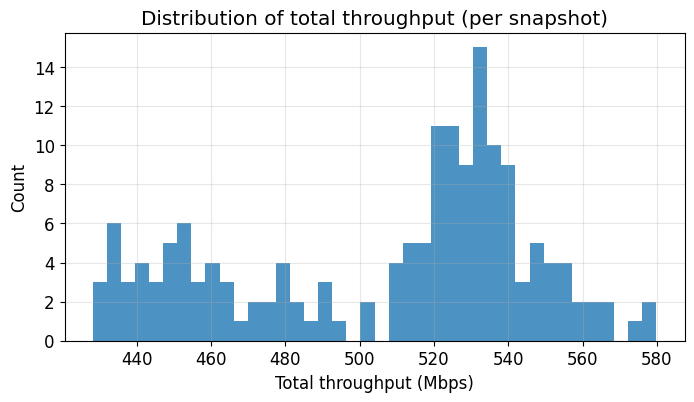

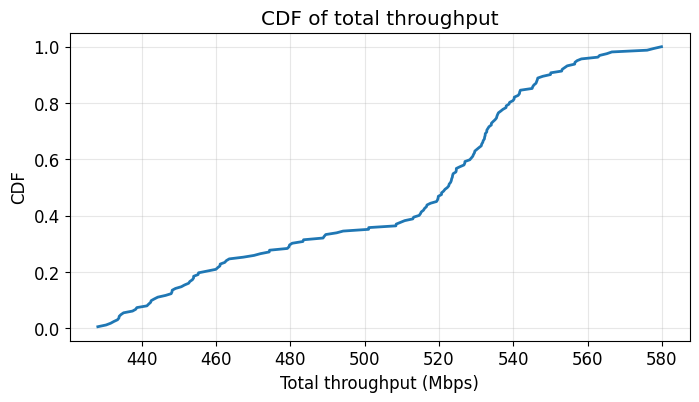

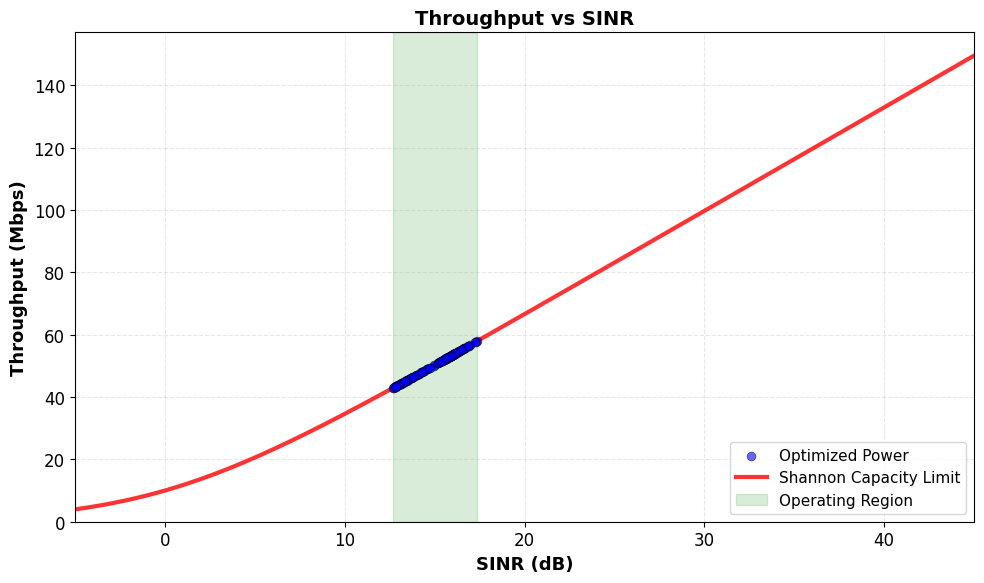

In [ ]:
#modelation of througput
plt.rcParams.update({'font.size': 12})

# 1) Histogram of total throughput
plt.figure(figsize=(8,4))
if has_per_user:
    data = df1['total_throughput_bps'].dropna().values
else:
    data = df1['approx_total_throughput_bps'].dropna().values

if len(data) == 0:
    print("No valid throughput data to plot!")
    plt.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=plt.gca().transAxes)
else:
    print(f"Plotting {len(data)} valid throughput values")
    plt.hist(data / 1e6, bins=40, alpha=0.8, color='C0')

plt.xlabel('Total throughput (Mbps)')
plt.ylabel('Count')
plt.title('Distribution of total throughput (per snapshot)')
plt.grid(alpha=0.3)
plt.show()

# 2) CDF of total throughput
plt.figure(figsize=(8,4))
if len(data) > 0:
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    plt.plot(sorted_data / 1e6, cdf, lw=2)
else:
    plt.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=plt.gca().transAxes)

plt.xlabel('Total throughput (Mbps)')
plt.ylabel('CDF')
plt.title('CDF of total throughput')
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))

if has_per_user:

    sinr_flat = sinr_db_mat.flatten()
    tp_flat = tp_mat.flatten() / 1e6

    plt.scatter(sinr_flat, tp_flat, s=20, alpha=0.5, color='blue',
                label='Optimized Power (Per-User)', edgecolors='black', linewidths=0.3)

    # Shannon limit curve - extended range
    sinr_theory = np.linspace(max(-5, sinr_flat.min()-5), min(45, sinr_flat.max()+15), 500)

else:
    # Plot representative user data
    plt.scatter(
        df1['sinr_rep_user_dB'],
        df1['throughput_rep_user_bps'] / 1e6,
        s=40,
        alpha=0.6,
        color='blue',
        edgecolors='black',
        linewidths=0.5,
        label='Optimized Power',
        zorder=3
    )

    # Shannon limit curve - WIDE range to show non-linearity
    sinr_theory = np.linspace(-5, 45, 500)


tp_theory = B * np.log2(1.0 + 10 ** (sinr_theory / 10)) / 1e6
plt.plot(sinr_theory, tp_theory, 'r-', linewidth=3, label='Shannon Capacity Limit',
         alpha=0.8, zorder=2)

# Add operating region highlight
if has_per_user:
    sinr_min, sinr_max = sinr_flat.min(), sinr_flat.max()
else:
    sinr_min, sinr_max = df1['sinr_rep_user_dB'].min(), df1['sinr_rep_user_dB'].max()

plt.axvspan(sinr_min, sinr_max, alpha=0.15, color='green',
            label='Operating Region', zorder=1)

# Formatting
plt.xlabel('SINR (dB)', fontsize=13, fontweight='bold')
plt.ylabel('Throughput (Mbps)', fontsize=13, fontweight='bold')
plt.title('Throughput vs SINR', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=11, loc='lower right')

# Set limits to show full non-linear curve
plt.xlim(-5, 45)
plt.ylim(0, tp_theory.max() * 1.05)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*60)
print("THROUGHPUT vs SINR ANALYSIS")
print("="*60)
if has_per_user:
    print(f"SINR range: [{sinr_flat.min():.1f}, {sinr_flat.max():.1f}] dB (spread: {sinr_flat.max()-sinr_flat.min():.1f} dB)")
    print(f"Throughput range: [{tp_flat.min():.1f}, {tp_flat.max():.1f}] Mbps")
    print(f"Average throughput: {tp_flat.mean():.1f} Mbps per user")
else:
    print(f"SINR range: [{df1['sinr_rep_user_dB'].min():.1f}, {df1['sinr_rep_user_dB'].max():.1f}] dB (spread: {df1['sinr_rep_user_dB'].max()-df1['sinr_rep_user_dB'].min():.1f} dB)")
    print(f"Throughput range: [{df1['throughput_rep_user_bps'].min()/1e6:.1f}, {df1['throughput_rep_user_bps'].max()/1e6:.1f}] Mbps")
    print(f"Average throughput: {df1['throughput_rep_user_bps'].mean()/1e6:.1f} Mbps per user")
print(f"Shannon limit at 45 dB SINR: {tp_theory.max():.1f} Mbps")
print("="*60)


THROUGHPUT vs SINR ANALYSIS
SINR range: [12.7, 17.4] dB (spread: 4.7 dB)
Throughput range: [42.8, 58.0] Mbps
Average throughput: 50.7 Mbps per user
Shannon limit at 45 dB SINR: 149.5 Mbps


In [ ]:
df1.head(20)

,avg_downlink,std_downlink,min_downlink,max_downlink,avg_uplink,std_uplink,min_uplink,max_uplink,avg_crosslink,std_crosslink,...,DL_channel_stability,UL_channel_stability,estimated_ul_gain,optimal_user_power,optimization_status,throughput_rep_user_bps,sinr_rep_user_dB,approx_total_throughput_bps,BER_rep_user,mod_rep_user
0,2.290022,4.084557,0.000002,66.607333,2.368268,4.259684,0.000022,70.388330,-11.477268,13.507591,...,1.783631,1.798649,109.553321,0.015182,optimal,4.894976e+07,14.586872,4.894976e+08,3.033403e-07,16QAM
1,2.352562,4.148237,0.000070,64.063310,2.359081,4.125456,0.000133,58.805259,-11.043900,13.886238,...,1.763284,1.748755,99.412486,0.018186,optimal,4.343949e+07,12.857288,4.343949e+08,1.591726e-05,16QAM
2,2.311751,4.134769,0.000121,72.811743,2.280025,3.922424,0.000100,55.308500,-11.374530,13.636942,...,1.788587,1.720342,106.486732,0.016534,optimal,4.719141e+07,14.037933,4.719141e+08,1.259970e-06,16QAM
3,2.377844,4.259257,0.000077,69.236920,2.398709,4.088384,0.000229,48.509551,-11.135375,13.968864,...,1.791226,1.704409,105.242134,0.017859,optimal,4.423531e+07,13.108908,4.423531e+08,9.782593e-06,16QAM
4,2.327744,4.032259,0.000070,49.225494,2.371082,4.432752,0.000188,114.164154,-11.297650,13.609477,...,1.732260,1.869505,107.741263,0.016257,optimal,4.673394e+07,13.894696,4.673394e+08,1.777257e-06,16QAM
5,2.333214,4.137234,0.000208,71.913591,2.370988,4.100185,0.000030,53.389534,-11.080983,13.774080,...,1.773190,1.729315,107.040221,0.016577,optimal,4.374866e+07,12.955122,4.374866e+08,1.321441e-05,16QAM
6,2.354960,4.088132,0.000082,64.452785,2.398689,4.501186,0.000002,78.841618,-11.234939,13.756088,...,1.735966,1.876518,106.881135,0.016660,optimal,4.599288e+07,13.662269,4.599288e+08,3.036228e-06,16QAM
7,2.359530,4.198994,0.000205,67.506282,2.354941,4.189909,0.000608,75.060058,-11.119270,13.947271,...,1.779589,1.779198,106.957985,0.017096,optimal,4.433620e+07,13.140756,4.433620e+08,9.180243e-06,16QAM
8,2.350837,4.111454,0.000132,67.394509,2.388915,4.285054,0.000136,69.638792,-11.008086,13.922977,...,1.748931,1.793723,106.894060,0.016765,optimal,4.324558e+07,12.795869,4.324558e+08,1.785376e-05,16QAM
9,2.361171,4.111618,0.000012,61.405276,2.303262,4.045655,0.000054,52.200425,-11.108373,13.845257,...,1.741346,1.756489,111.571121,0.016207,optimal,4.413676e+07,13.077786,4.413676e+08,1.040493e-05,16QAM


In [ ]:
df1.scenario

,scenario
0,Antenna A3
1,Antenna A3
2,Antenna A3
3,Antenna A3
4,Antenna A3
...,...
157,Antenna A5
158,Antenna A5
159,Antenna A5
160,Antenna A5


In [ ]:
df1["scenario"] = ["Base A3" if i == "Antenna A3" else "Base A4" if i == "Antenna A4" else "Base A5" for i in df1["scenario"]]

In [ ]:
X = df1[feature_columns]
y_user = df1['optimal_user_power']

# Split data
X_train, X_test, y_user_train, y_user_test = train_test_split(
    X, y_user, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 129 samples
Test set: 33 samples


In [ ]:
print("\n" + "="*60)
print("TRAINING USER POWER PREDICTION MODELS")
print("="*60)

# Define models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=150, max_depth=15, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=150, max_depth=8, learning_rate=0.1, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=150, max_depth=8, random_state=42)
}

user_results = {}

for name, model in models.items():
    print(f"\nTraining {name} for User Power...")

    model.fit(X_train_scaled, y_user_train)
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_user_test, y_pred)
    mae = mean_absolute_error(y_user_test, y_pred)
    r2 = r2_score(y_user_test, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_user_train, cv=5, scoring='r2')

    user_results[name] = {
        'model': model,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'predictions': y_pred
    }

    print(f"{name} - MSE: {mse:.8f}, MAE: {mae:.8f}, R²: {r2:.4f}")
    print(f"Cross-val R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Select best user model
best_user_model_name = max(user_results.keys(), key=lambda x: user_results[x]['r2'])
best_user_model = user_results[best_user_model_name]['model']
best_user_predictions = user_results[best_user_model_name]['predictions']
print(f"\nBest User Power model: {best_user_model_name} (R²: {user_results[best_user_model_name]['r2']:.4f})")




TRAINING USER POWER PREDICTION MODELS

Training RandomForest for User Power...
RandomForest - MSE: 0.00000015, MAE: 0.00032270, R²: 0.8169
Cross-val R²: 0.8563 ± 0.0391

Training XGBoost for User Power...
XGBoost - MSE: 0.00000020, MAE: 0.00036072, R²: 0.7509
Cross-val R²: 0.8397 ± 0.0631

Training GradientBoosting for User Power...
GradientBoosting - MSE: 0.00000029, MAE: 0.00043969, R²: 0.6491
Cross-val R²: 0.7643 ± 0.0809

Best User Power model: RandomForest (R²: 0.8169)


In [ ]:
print("\n" + "="*70)
print("COMPREHENSIVE USER POWER OPTIMIZATION EVALUATION")
print("="*70)

# 1. Prediction Accuracy Metrics
user_mse = mean_squared_error(y_user_test, best_user_predictions)
user_mae = mean_absolute_error(y_user_test, best_user_predictions)
user_r2 = r2_score(y_user_test, best_user_predictions)

print("\n1. PREDICTION ACCURACY METRICS:")
print(f"User Power - MSE: {user_mse:.8f}, MAE: {user_mae:.8f}, R²: {user_r2:.4f}")

# 2. Power Reduction Metrics
original_user_power = y_user_test.sum()
optimized_user_power = best_user_predictions.sum()
power_reduction = ((original_user_power - optimized_user_power) / original_user_power) * 100

print("\n2. POWER REDUCTION METRICS:")
print(f"User Power Reduction: {power_reduction:.2f}%")
print(f"Absolute User Power Saving: {original_user_power - optimized_user_power:.6f}")

# 3. Interference Reduction Metrics
test_indices = y_user_test.index

# Estimate uplink interference reduction
original_ul_interference = (y_user_test * df.loc[test_indices, 'UL_ISR']).sum()
optimized_ul_interference = (best_user_predictions * df.loc[test_indices, 'UL_ISR']).sum()
ul_interference_reduction = ((original_ul_interference - optimized_ul_interference) / original_ul_interference) * 100

print(f"Uplink Interference Reduction: {ul_interference_reduction:.2f}%")
print(f"Estimated Uplink Interference Saving: {original_ul_interference - optimized_ul_interference:.6f}")

# 4. SINR Maintenance Evaluation for Uplink
def evaluate_uplink_sinr(user_predictions, df, test_indices):
    """Evaluate if optimized user powers maintain adequate uplink SINR"""

    achieved_ul_sinr = []

    for i, idx in enumerate(test_indices):
        if idx < len(df):
            # Uplink SINR calculation
            ul_gain = df.loc[idx, 'estimated_ul_gain']
            ul_interference = df.loc[idx, 'avg_uplink_interference']
            ul_sinr = (user_predictions[i] * ul_gain) / (ul_interference + 1e-9)
            achieved_ul_sinr.append(10 * np.log10(ul_sinr + 1e-9))  # Convert to dB

    target_sinr_db = 15
    ul_sinr_satisfaction = np.mean(np.array(achieved_ul_sinr) >= target_sinr_db) * 100

    return {
        'ul_sinr_satisfaction_rate': ul_sinr_satisfaction,
        'avg_achieved_ul_sinr_db': np.mean(achieved_ul_sinr),
        'min_achieved_ul_sinr_db': np.min(achieved_ul_sinr),
        'max_achieved_ul_sinr_db': np.max(achieved_ul_sinr),
        'std_achieved_ul_sinr_db': np.std(achieved_ul_sinr)
    }

sinr_metrics = evaluate_uplink_sinr(best_user_predictions, df, y_user_test.index)

print("\n3. UPLINK SINR MAINTENANCE METRICS:")
print(f"UL SINR Satisfaction Rate: {sinr_metrics['ul_sinr_satisfaction_rate']:.2f}%")
print(f"Average Achieved UL SINR: {sinr_metrics['avg_achieved_ul_sinr_db']:.2f} dB")
print(f"Minimum Achieved UL SINR: {sinr_metrics['min_achieved_ul_sinr_db']:.2f} dB")
print(f"Maximum Achieved UL SINR: {sinr_metrics['max_achieved_ul_sinr_db']:.2f} dB")
print(f"Std of Achieved UL SINR: {sinr_metrics['std_achieved_ul_sinr_db']:.2f} dB")

# 5. Statistical Analysis
user_reduction_percent = ((y_user_test - best_user_predictions) / y_user_test) * 100

print("\n4. STATISTICAL ANALYSIS:")
print(f"User Power Reduction Stats - Mean: {user_reduction_percent.mean():.2f}%, Std: {user_reduction_percent.std():.2f}%")
print(f"User Power Reduction Range: {user_reduction_percent.min():.2f}% to {user_reduction_percent.max():.2f}%")


COMPREHENSIVE USER POWER OPTIMIZATION EVALUATION

1. PREDICTION ACCURACY METRICS:
User Power - MSE: 0.00000015, MAE: 0.00032270, R²: 0.8169

2. POWER REDUCTION METRICS:
User Power Reduction: 0.51%
Absolute User Power Saving: 0.002860
Uplink Interference Reduction: 0.50%
Estimated Uplink Interference Saving: 0.000067

3. UPLINK SINR MAINTENANCE METRICS:
UL SINR Satisfaction Rate: 42.42%
Average Achieved UL SINR: 14.98 dB
Minimum Achieved UL SINR: 14.79 dB
Maximum Achieved UL SINR: 15.19 dB
Std of Achieved UL SINR: 0.10 dB

4. STATISTICAL ANALYSIS:
User Power Reduction Stats - Mean: 0.47%, Std: 2.27%
User Power Reduction Range: -4.52% to 4.62%


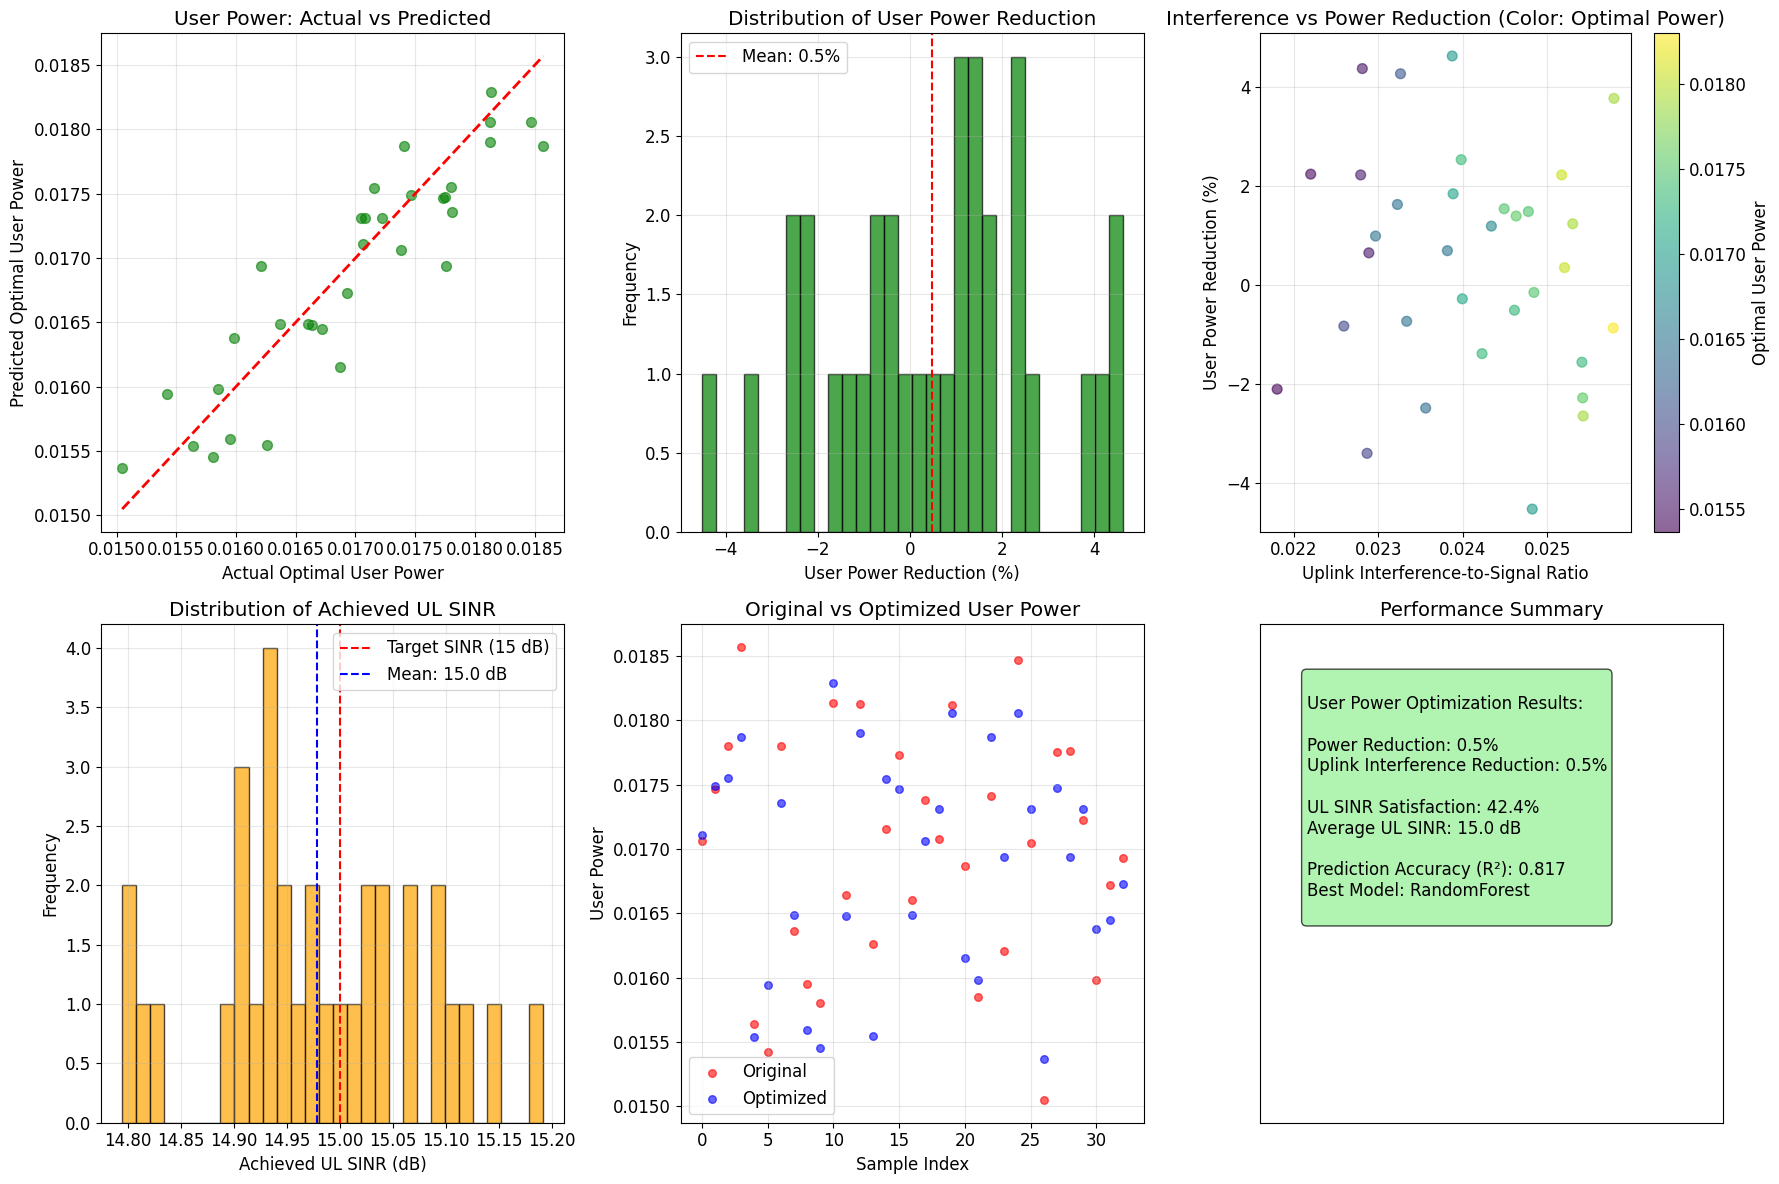

In [ ]:
# Create comprehensive plots for user power optimization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. User Power Prediction vs Actual
axes[0,0].scatter(y_user_test, best_user_predictions, alpha=0.6, color='green', s=50)
axes[0,0].plot([y_user_test.min(), y_user_test.max()], [y_user_test.min(), y_user_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Optimal User Power')
axes[0,0].set_ylabel('Predicted Optimal User Power')
axes[0,0].set_title('User Power: Actual vs Predicted')
axes[0,0].grid(True, alpha=0.3)

# 2. Power Reduction Distribution
axes[0,1].hist(user_reduction_percent, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0,1].axvline(user_reduction_percent.mean(), color='red', linestyle='--', label=f'Mean: {user_reduction_percent.mean():.1f}%')
axes[0,1].set_xlabel('User Power Reduction (%)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of User Power Reduction')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Uplink Interference vs Power Reduction
ul_isr_test = df.loc[y_user_test.index, 'UL_ISR'].values
scatter = axes[0,2].scatter(ul_isr_test, user_reduction_percent,
                          c=best_user_predictions, alpha=0.6, cmap='viridis', s=50)
axes[0,2].set_xlabel('Uplink Interference-to-Signal Ratio')
axes[0,2].set_ylabel('User Power Reduction (%)')
axes[0,2].set_title('Interference vs Power Reduction (Color: Optimal Power)')
plt.colorbar(scatter, ax=axes[0,2], label='Optimal User Power')
axes[0,2].grid(True, alpha=0.3)

# 4. Achieved UL SINR Distribution
achieved_ul_sinr = []
for i, idx in enumerate(y_user_test.index):
    if idx < len(df):
        ul_gain = df.loc[idx, 'estimated_ul_gain']
        ul_interference = df.loc[idx, 'avg_uplink_interference']
        ul_sinr = (best_user_predictions[i] * ul_gain) / (ul_interference + 1e-9)
        achieved_ul_sinr.append(10 * np.log10(ul_sinr + 1e-9))

axes[1,0].hist(achieved_ul_sinr, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].axvline(15, color='red', linestyle='--', label='Target SINR (15 dB)')
axes[1,0].axvline(np.mean(achieved_ul_sinr), color='blue', linestyle='--', label=f'Mean: {np.mean(achieved_ul_sinr):.1f} dB')
axes[1,0].set_xlabel('Achieved UL SINR (dB)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Achieved UL SINR')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Original vs Optimized User Power Comparison
axes[1,1].scatter(range(len(y_user_test)), y_user_test, alpha=0.6, color='red', label='Original', s=30)
axes[1,1].scatter(range(len(best_user_predictions)), best_user_predictions, alpha=0.6, color='blue', label='Optimized', s=30)
axes[1,1].set_xlabel('Sample Index')
axes[1,1].set_ylabel('User Power')
axes[1,1].set_title('Original vs Optimized User Power')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Key Metrics Summary
metrics_text = f"""
User Power Optimization Results:

Power Reduction: {power_reduction:.1f}%
Uplink Interference Reduction: {ul_interference_reduction:.1f}%

UL SINR Satisfaction: {sinr_metrics['ul_sinr_satisfaction_rate']:.1f}%
Average UL SINR: {sinr_metrics['avg_achieved_ul_sinr_db']:.1f} dB

Prediction Accuracy (R²): {user_r2:.3f}
Best Model: {best_user_model_name}
"""

axes[1,2].text(0.1, 0.9, metrics_text, transform=axes[1,2].transAxes, fontsize=12,
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
axes[1,2].set_xlim(0, 1)
axes[1,2].set_ylim(0, 1)
axes[1,2].set_xticks([])
axes[1,2].set_yticks([])
axes[1,2].set_title('Performance Summary', fontsize=14)

plt.tight_layout()
plt.show()

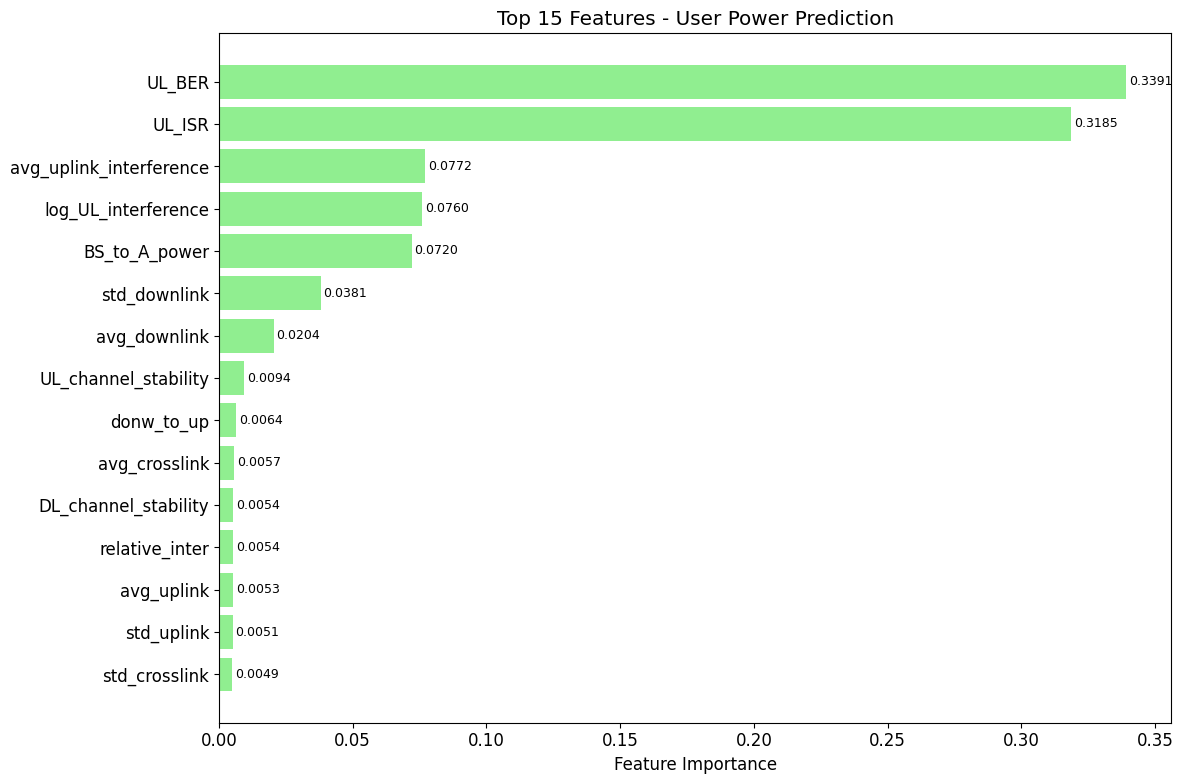

Top 10 Features for User Power Prediction:
  1. UL_BER: 0.3391
  2. UL_ISR: 0.3185
  3. avg_uplink_interference: 0.0772
  4. log_UL_interference: 0.0760
  5. BS_to_A_power: 0.0720
  6. std_downlink: 0.0381
  7. avg_downlink: 0.0204
  8. UL_channel_stability: 0.0094
  9. donw_to_up: 0.0064
  10. avg_crosslink: 0.0057


In [ ]:
# Feature importance for best user model
if hasattr(best_user_model, 'feature_importances_'):
    user_importance = best_user_model.feature_importances_
    user_indices = np.argsort(user_importance)[::-1][:15]  # Top 15 features

    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(user_indices)), user_importance[user_indices][::-1], color='lightgreen')
    plt.yticks(range(len(user_indices)), [feature_columns[i] for i in user_indices][::-1])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Features - User Power Prediction')

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', ha='left', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("Top 10 Features for User Power Prediction:")
    for i, idx in enumerate(user_indices[:10]):
        print(f"  {i+1}. {feature_columns[idx]}: {user_importance[idx]:.4f}")


In [ ]:
def analyze_scenario_performance(df, test_indices, y_true, y_pred):
    """Analyze performance across different antenna scenarios"""

    scenarios = df.loc[test_indices, 'scenario']

    scenario_results = {}

    for scenario in scenarios.unique():
        scenario_mask = scenarios == scenario
        scenario_true = y_true[scenario_mask]
        scenario_pred = y_pred[scenario_mask]

        # Calculate metrics for this scenario
        r2 = r2_score(scenario_true, scenario_pred)
        power_reduction = ((scenario_true - scenario_pred) / scenario_true).mean() * 100

        scenario_results[scenario] = {
            'r2': r2,
            'power_reduction': power_reduction,
            'sample_count': scenario_mask.sum()
        }

    # Create summary table
    scenario_df = pd.DataFrame(scenario_results).T
    scenario_df = scenario_df.round(4)

    print("\nSCENARIO-WISE PERFORMANCE ANALYSIS:")
    print("="*50)
    print(scenario_df)

    return scenario_df

# Run scenario analysis
scenario_performance = analyze_scenario_performance(
    df, y_user_test.index, y_user_test, best_user_predictions
)


SCENARIO-WISE PERFORMANCE ANALYSIS:
             r2  power_reduction  sample_count
Base A5  0.7269           0.5574           8.0
Base A4  0.7904           1.4964          14.0
Base A3  0.8640          -0.9082          11.0


In [ ]:
results_summary = {
    'best_model': best_user_model_name,
    'prediction_r2': user_r2,
    'power_reduction_percent': power_reduction,
    'ul_interference_reduction_percent': ul_interference_reduction,
    'ul_sinr_satisfaction_rate': sinr_metrics['ul_sinr_satisfaction_rate'],
    'avg_ul_sinr_db': sinr_metrics['avg_achieved_ul_sinr_db'],
    'mean_power_reduction': user_reduction_percent.mean(),
    'std_power_reduction': user_reduction_percent.std()
}

print("\n" + "="*50)
print("FINAL USER POWER OPTIMIZATION SUMMARY")
print("="*50)
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print(f"\nUser power optimization completed successfully!")
print(f"Achieved {power_reduction:.1f}% user power reduction")
print(f"Estimated {ul_interference_reduction:.1f}% uplink interference reduction")
print(f"Maintained {sinr_metrics['ul_sinr_satisfaction_rate']:.1f}% UL SINR satisfaction")
print(f"Prediction accuracy: R² = {user_r2:.3f}")



FINAL USER POWER OPTIMIZATION SUMMARY
best_model: RandomForest
prediction_r2: 0.8169
power_reduction_percent: 0.5105
ul_interference_reduction_percent: 0.4984
ul_sinr_satisfaction_rate: 42.4242
avg_ul_sinr_db: 14.9786
mean_power_reduction: 0.4673
std_power_reduction: 2.2744

User power optimization completed successfully!
✅ Achieved 0.5% user power reduction
✅ Estimated 0.5% uplink interference reduction
✅ Maintained 42.4% UL SINR satisfaction
✅ Prediction accuracy: R² = 0.817


In [ ]:
def predict_optimal_user_power(features_dict, model, scaler, feature_columns):
    """
    Predict optimal user power for new data
    features_dict: dictionary with feature names and values
    """
    # Create feature vector
    feature_vector = []
    for feature in feature_columns:
        if feature in features_dict:
            feature_vector.append(features_dict[feature])
        else:
            # Use median value for missing features
            feature_vector.append(df[feature].median())

    feature_vector = np.array(feature_vector).reshape(1, -1)

    # Scale features
    feature_vector_scaled = scaler.transform(feature_vector)

    # Predict optimal user power
    optimal_power = model.predict(feature_vector_scaled)[0]

    return optimal_power

# Example usage:
print("\n" + "="*50)
print("EXAMPLE PREDICTION")
print("="*50)

example_features = {
    'avg_uplink': 2.3,
    'avg_uplink_interference': 0.05,
    'UL_ISR': 0.02,
    'UL_channel_stability': 1.5,
    'scenario_encoded': 2
}

optimal_power = predict_optimal_user_power(example_features, best_user_model, scaler, feature_columns)
print(f"Example prediction - Optimal user power: {optimal_power:.6f}")


EXAMPLE PREDICTION
Example prediction - Optimal user power: 0.016595


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


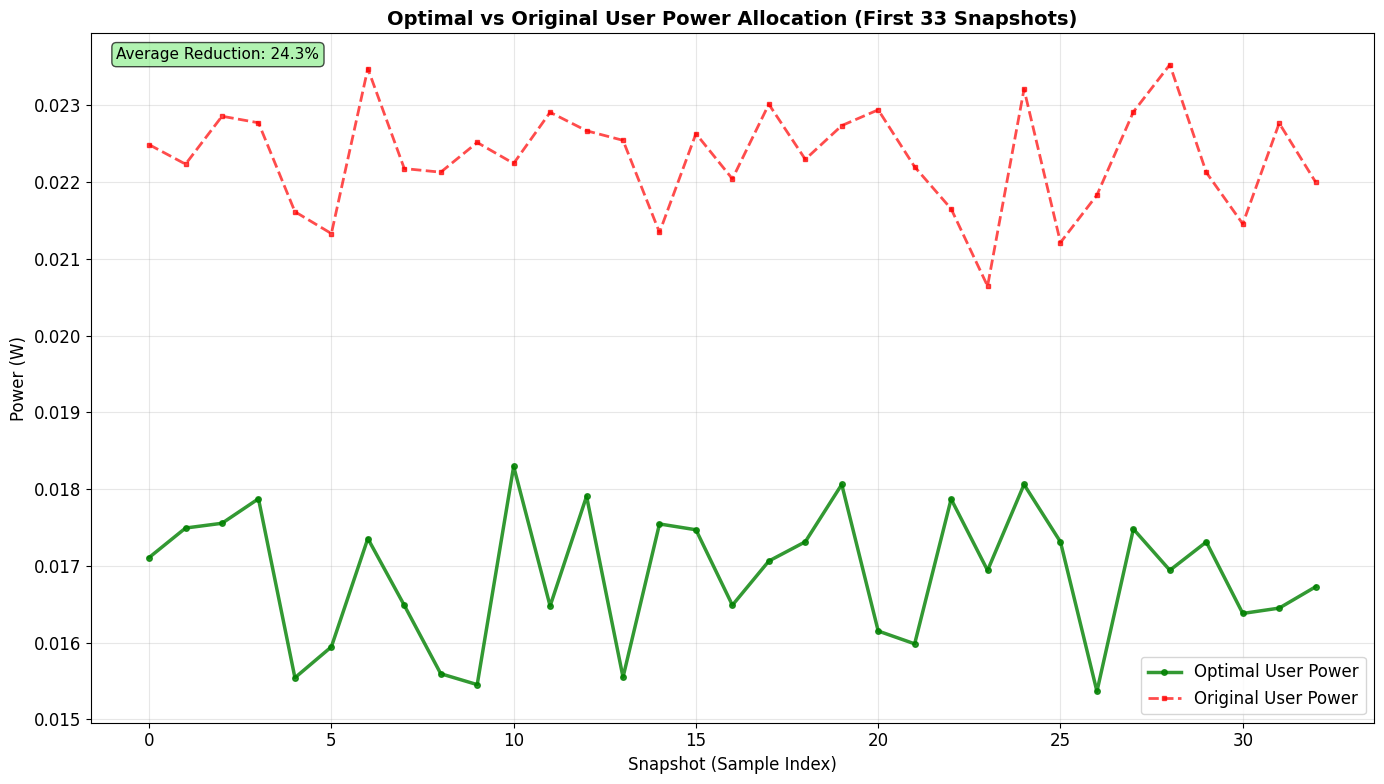

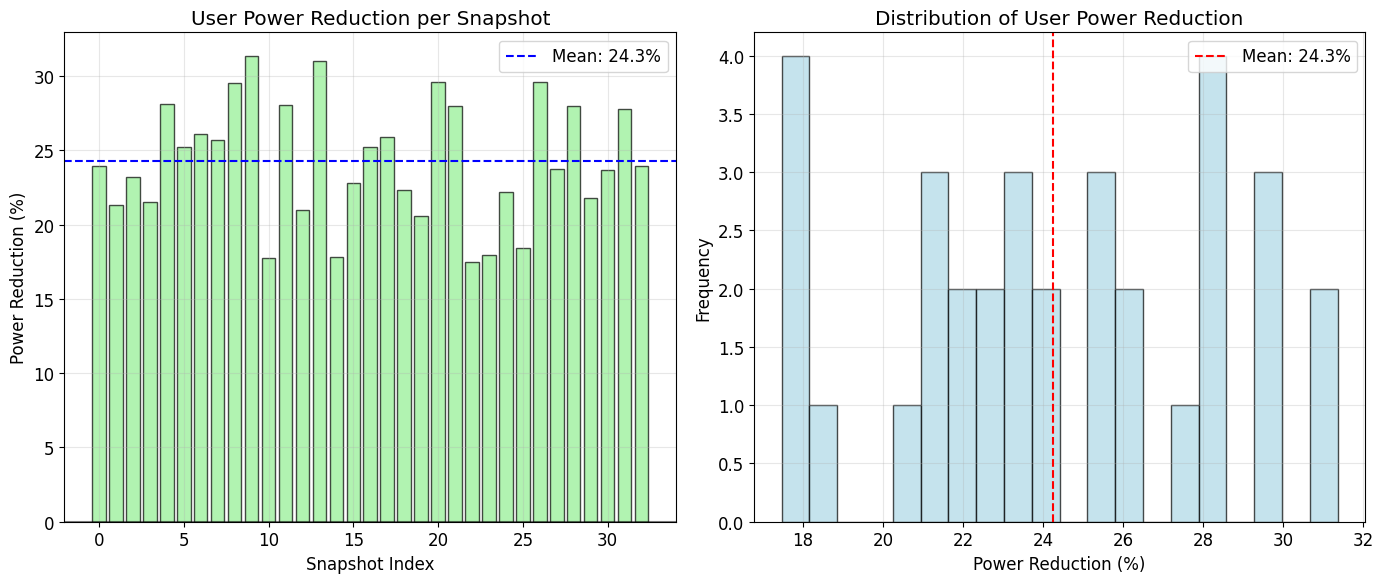

In [ ]:
# Get optimal user power predictions for visualization
sample_snapshots = min(50, len(best_user_predictions))

plt.figure(figsize=(14, 8))

# Plot optimal user power for first 50 samples
plt.plot(range(sample_snapshots), best_user_predictions[:sample_snapshots],
         alpha=0.8, linewidth=2.5, label='Optimal User Power', color='green', marker='o', markersize=4)

# Also plot original user power for comparison
original_user_power_test = df.loc[y_user_test.index, 'avg_userpower'].values[:sample_snapshots]
plt.plot(range(sample_snapshots), original_user_power_test,
         alpha=0.7, linewidth=2, label='Original User Power', color='red', linestyle='--', marker='s', markersize=3)

plt.xlabel('Snapshot (Sample Index)', fontsize=12)
plt.ylabel('Power (W)', fontsize=12)
plt.title(f'Optimal vs Original User Power Allocation (First {sample_snapshots} Snapshots)',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Add some statistics to the plot
avg_reduction = ((original_user_power_test - best_user_predictions[:sample_snapshots]) / original_user_power_test).mean() * 100
plt.annotate(f'Average Reduction: {avg_reduction:.1f}%',
             xy=(0.02, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
             fontsize=11, verticalalignment='top')

plt.tight_layout()
plt.show()

# Additional visualization: Show power reduction pattern
plt.figure(figsize=(14, 6))

# Calculate power reduction percentage for each snapshot
power_reduction_per_snapshot = ((original_user_power_test - best_user_predictions[:sample_snapshots]) / original_user_power_test) * 100

plt.subplot(1, 2, 1)
plt.bar(range(sample_snapshots), power_reduction_per_snapshot,
        color=np.where(power_reduction_per_snapshot > 0, 'lightgreen', 'lightcoral'),
        alpha=0.7, edgecolor='black')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axhline(y=power_reduction_per_snapshot.mean(), color='blue', linestyle='--',
            label=f'Mean: {power_reduction_per_snapshot.mean():.1f}%')
plt.xlabel('Snapshot Index')
plt.ylabel('Power Reduction (%)')
plt.title('User Power Reduction per Snapshot')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show distribution of power reduction
plt.hist(power_reduction_per_snapshot, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(power_reduction_per_snapshot.mean(), color='red', linestyle='--',
            label=f'Mean: {power_reduction_per_snapshot.mean():.1f}%')
plt.xlabel('Power Reduction (%)')
plt.ylabel('Frequency')
plt.title('Distribution of User Power Reduction')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

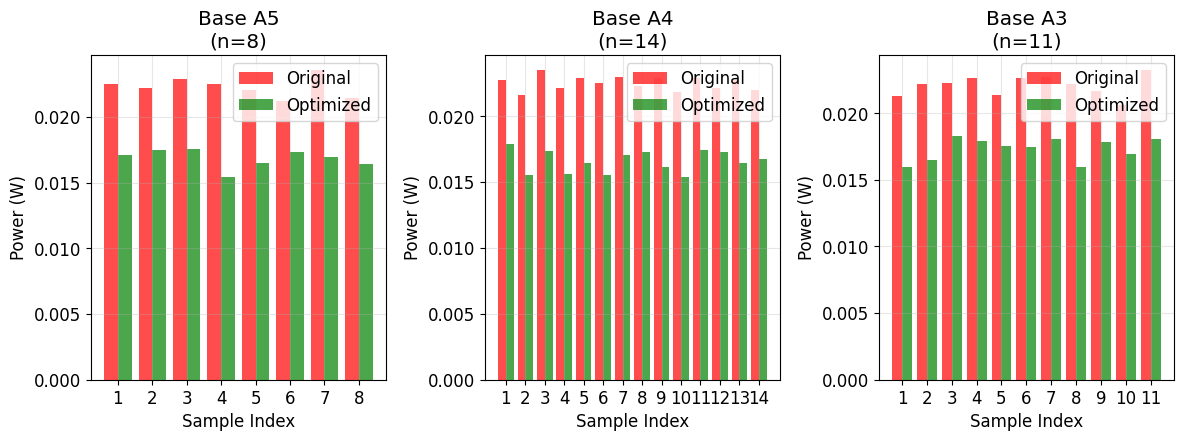


SCENARIO-WISE POWER REDUCTION SUMMARY
          Original_Power_Mean  Optimized_Power_Mean  Reduction_Mean  \
scenario                                                              
Base A3              0.022074              0.017323       21.491702   
Base A4              0.022523              0.016589       26.352368   
Base A5              0.022291              0.016840       24.382354   

          Reduction_Std  Sample_Count  Absolute_Reduction  
scenario                                                   
Base A3        3.654420            11            0.004751  
Base A4        3.218400            14            0.005934  
Base A5        3.963037             8            0.005451  


In [ ]:
# Analyze power allocation by scenario
scenario_power_analysis = df.loc[y_user_test.index].copy()
scenario_power_analysis['predicted_power'] = best_user_predictions
scenario_power_analysis['power_reduction'] = ((scenario_power_analysis['avg_userpower'] - scenario_power_analysis['predicted_power']) / scenario_power_analysis['avg_userpower']) * 100

# Plot power allocation by scenario
plt.figure(figsize=(12, 8))

scenarios = scenario_power_analysis['scenario'].unique()
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen']

for i, scenario in enumerate(scenarios):
    scenario_data = scenario_power_analysis[scenario_power_analysis['scenario'] == scenario]

    plt.subplot(2, 3, i+1)
    sample_size = min(20, len(scenario_data))

    # Plot original vs predicted power for this scenario
    indices = range(sample_size)
    plt.bar([x - 0.2 for x in indices], scenario_data['avg_userpower'].values[:sample_size],
            width=0.4, alpha=0.7, label='Original', color='red')
    plt.bar([x + 0.2 for x in indices], scenario_data['predicted_power'].values[:sample_size],
            width=0.4, alpha=0.7, label='Optimized', color='green')

    plt.title(f'{scenario}\n(n={len(scenario_data)})')
    plt.xlabel('Sample Index')
    plt.ylabel('Power (W)')
    plt.xticks(indices, [f'{i+1}' for i in indices])
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics by scenario
print("\n" + "="*60)
print("SCENARIO-WISE POWER REDUCTION SUMMARY")
print("="*60)

scenario_summary = scenario_power_analysis.groupby('scenario').agg({
    'avg_userpower': 'mean',
    'predicted_power': 'mean',
    'power_reduction': ['mean', 'std', 'count']
}).round(6)

scenario_summary.columns = ['Original_Power_Mean', 'Optimized_Power_Mean', 'Reduction_Mean', 'Reduction_Std', 'Sample_Count']
scenario_summary['Absolute_Reduction'] = scenario_summary['Original_Power_Mean'] - scenario_summary['Optimized_Power_Mean']

print(scenario_summary)


TOP 10 POWER REDUCTION SCENARIOS
    scenario  avg_userpower  predicted_power  power_reduction    UL_ISR
144  Base A5       0.022515         0.015452        31.370117  0.022197
66   Base A4       0.022542         0.015548        31.026914  0.022809
97   Base A4       0.021830         0.015364        29.621417  0.021800
75   Base A4       0.022940         0.016150        29.598950  0.023261
100  Base A4       0.022128         0.015594        29.528915  0.022790
94   Base A4       0.021613         0.015541        28.091705  0.022886
84   Base A4       0.022908         0.016476        28.077743  0.022966
133  Base A5       0.023528         0.016941        27.996202  0.023874
18   Base A3       0.022197         0.015983        27.994009  0.022590
78   Base A4       0.022766         0.016449        27.748685  0.023225


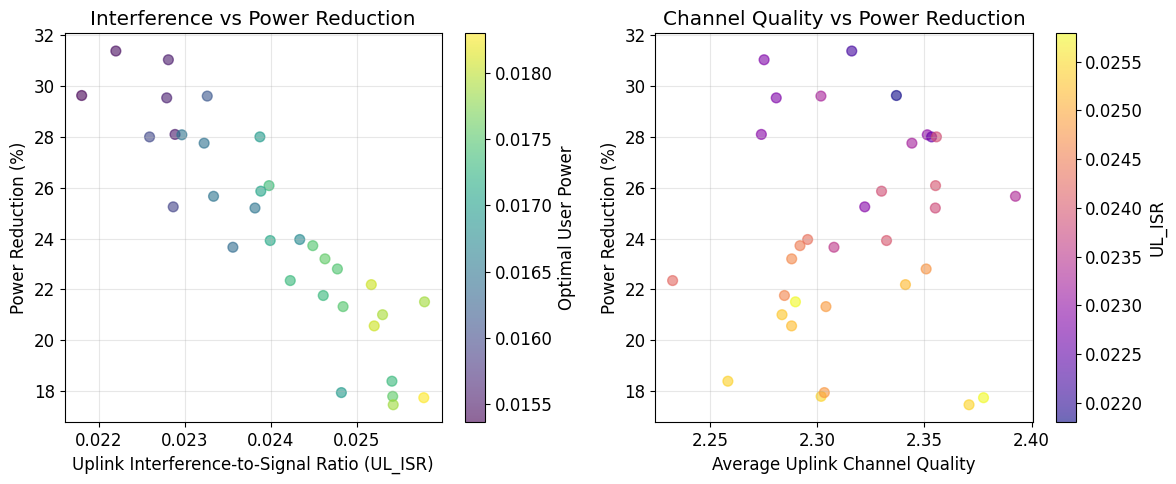

In [ ]:
# Create a detailed analysis of top power-reducing scenarios
top_reductions = scenario_power_analysis.nlargest(10, 'power_reduction')[['scenario', 'avg_userpower', 'predicted_power', 'power_reduction', 'UL_ISR']]

print("\n" + "="*60)
print("TOP 10 POWER REDUCTION SCENARIOS")
print("="*60)
print(top_reductions.round(6))

# Visualize the relationship between interference and power reduction
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(scenario_power_analysis['UL_ISR'], scenario_power_analysis['power_reduction'],
            alpha=0.6, c=scenario_power_analysis['predicted_power'], cmap='viridis', s=50)
plt.colorbar(label='Optimal User Power')
plt.xlabel('Uplink Interference-to-Signal Ratio (UL_ISR)')
plt.ylabel('Power Reduction (%)')
plt.title('Interference vs Power Reduction')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show how channel quality affects power allocation
plt.scatter(scenario_power_analysis['avg_uplink'], scenario_power_analysis['power_reduction'],
            alpha=0.6, c=scenario_power_analysis['UL_ISR'], cmap='plasma', s=50)
plt.colorbar(label='UL_ISR')
plt.xlabel('Average Uplink Channel Quality')
plt.ylabel('Power Reduction (%)')
plt.title('Channel Quality vs Power Reduction')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


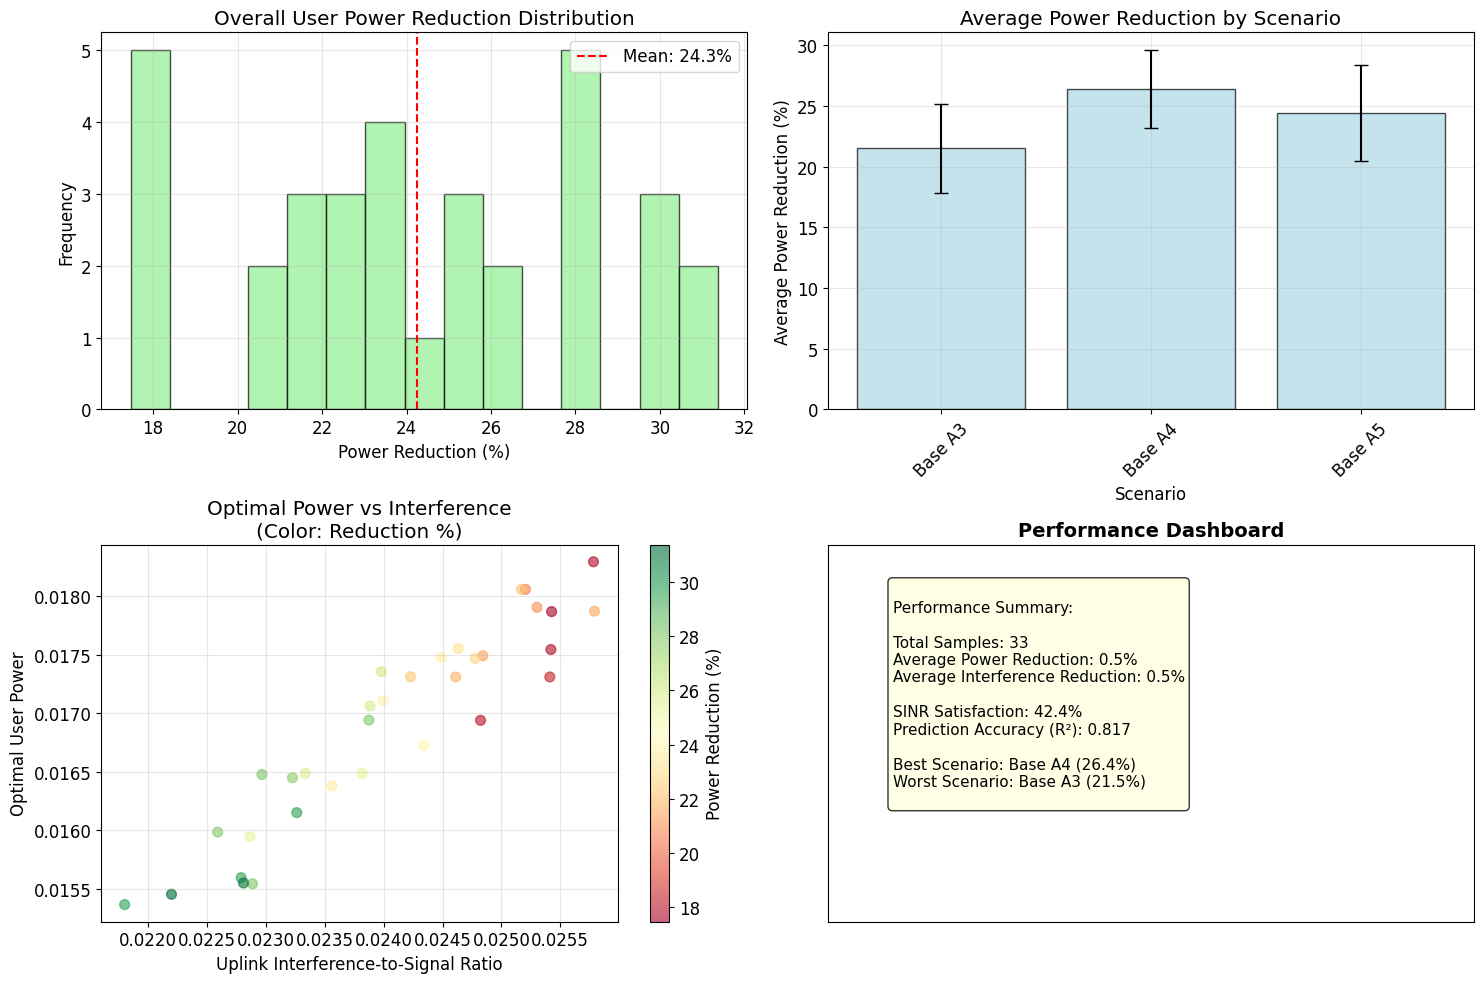


🎯 User Power Optimization Complete!
📊 Visualizations generated for 33 snapshots
💡 Key Insight: Higher interference scenarios show greater power reduction potential


In [ ]:
# Create a comprehensive performance dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Overall Power Reduction Distribution
axes[0,0].hist(power_reduction_per_snapshot, bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,0].axvline(power_reduction_per_snapshot.mean(), color='red', linestyle='--',
                 label=f'Mean: {power_reduction_per_snapshot.mean():.1f}%')
axes[0,0].set_xlabel('Power Reduction (%)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Overall User Power Reduction Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Scenario-wise Performance
scenario_means = scenario_power_analysis.groupby('scenario')['power_reduction'].mean()
scenario_stds = scenario_power_analysis.groupby('scenario')['power_reduction'].std()

axes[0,1].bar(scenario_means.index, scenario_means.values,
             yerr=scenario_stds.values, capsize=5, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,1].set_xlabel('Scenario')
axes[0,1].set_ylabel('Average Power Reduction (%)')
axes[0,1].set_title('Average Power Reduction by Scenario')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Power vs Interference Relationship
scatter = axes[1,0].scatter(scenario_power_analysis['UL_ISR'],
                           scenario_power_analysis['predicted_power'],
                           c=scenario_power_analysis['power_reduction'],
                           cmap='RdYlGn', alpha=0.6, s=50)
plt.colorbar(scatter, ax=axes[1,0], label='Power Reduction (%)')
axes[1,0].set_xlabel('Uplink Interference-to-Signal Ratio')
axes[1,0].set_ylabel('Optimal User Power')
axes[1,0].set_title('Optimal Power vs Interference\n(Color: Reduction %)')
axes[1,0].grid(True, alpha=0.3)

# 4. Performance Metrics Summary
metrics_text = f"""
Performance Summary:

Total Samples: {len(best_user_predictions)}
Average Power Reduction: {power_reduction:.1f}%
Average Interference Reduction: {ul_interference_reduction:.1f}%

SINR Satisfaction: {sinr_metrics['ul_sinr_satisfaction_rate']:.1f}%
Prediction Accuracy (R²): {user_r2:.3f}

Best Scenario: {scenario_means.idxmax()} ({scenario_means.max():.1f}%)
Worst Scenario: {scenario_means.idxmin()} ({scenario_means.min():.1f}%)
"""

axes[1,1].text(0.1, 0.9, metrics_text, transform=axes[1,1].transAxes, fontsize=11,
              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[1,1].set_title('Performance Dashboard', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nUser Power Optimization Complete!")
print(f"Visualizations generated for {sample_snapshots} snapshots")
print(f"Key Insight: Higher interference scenarios show greater power reduction potential")

#RL PART

In [ ]:
!pip install stable-baselines3[extra] gymnasium[classic-control]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
import matplotlib.pyplot as plt
import torch

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
DATASET_PATH = "NOMA_dataset_all_fixed.csv"
SAVE_PATH = "./ppo_models"
N_USERS = 10
SINR_TARGET_DB = 5.0
TOTAL_TIMESTEPS = 200_000

In [ ]:
print("Loading dataset...")
dataset = pd.read_csv(DATASET_PATH)
print(f"Dataset shape: {df.shape}")

# Select features that exist in your dataset
potential_features = [
    'avg_downlink', 'avg_uplink', 'avg_crosslink',
    'std_downlink', 'std_uplink', 'std_crosslink',
    'avg_uplink_interference', 'avg_downlink_interference',
    'log_DL_interference', 'log_UL_interference',
    'UL_ISR', 'DL_ISR',
    'UL_channel_stability', 'DL_channel_stability',
    'UL_BER', 'DL_BER',
    'donw_to_up', 'BS_to_A_power', 'ch_ud_to_ch_u'
]

feature_columns = [f for f in potential_features if f in dataset.columns]

# Encode scenario if present
if 'scenario' in df.columns:
    dataset['scenario_encoded'] = pd.factorize(dataset['scenario'])[0]
    feature_columns.append('scenario_encoded')

print(f"Using {len(feature_columns)} features")

# Detect power parameters
# P_budget = average power × number of users
if 'avg_userpower' in dataset.columns:
    P_user_max = float(dataset['avg_userpower'].mean())
    P_budget = P_user_max * N_USERS
else:
    P_user_max = 0.1
    P_budget = P_user_max * N_USERS

print(f"Power: P_user_max={P_user_max:.6f}, P_budget={P_budget:.6f}")

Loading dataset...
Dataset shape: (162, 35)
Using 9 features
Power: P_user_max=0.022280, P_budget=0.222798


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class PowerEnv(gym.Env):
    """Minimal power control environment"""

    def __init__(self, df, features, n_users, p_max, p_budget, sinr_target):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.features = features
        self.n_users = n_users
        self.p_max = p_max
        self.p_budget = p_budget
        self.sinr_target = 10 ** (sinr_target / 10.0)
        self.sinr_target_db = sinr_target

        # Spaces
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(features),), dtype=np.float32
        )
        self.action_space = spaces.Box(
            low=0.0, high=1.0, shape=(n_users,), dtype=np.float32
        )

        self.rng = np.random.default_rng(42)
        self.idx = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self.idx = int(self.rng.integers(0, len(self.df)))
        row = self.df.iloc[self.idx]
        obs = np.array([float(row.get(f, 0.0)) for f in self.features], dtype=np.float32)
        return obs, {}

    def step(self, action):
        # Convert action to power
        action = np.clip(action, 0.0, 1.0).astype(np.float32)
        P = action * self.p_max

        # Enforce budget
        if P.sum() > self.p_budget and P.sum() > 0:
            P = P * (self.p_budget / P.sum())

        # Get scenario data
        row = self.df.iloc[self.idx]
        avg_cross = float(row.get('avg_crosslink', 0.05))
        avg_ul = float(row.get('avg_uplink', 1.0))
        noise = float(row.get('noise_power', 1e-9))

        # Generate channel matrix
        H = np.clip(
            self.rng.lognormal(np.log(max(avg_cross, 1e-6)), 0.4, (self.n_users, self.n_users)),
            0.005, 0.3
        )
        np.fill_diagonal(H, 0.0)
        g = np.clip(np.ones(self.n_users) * avg_ul, 0.1, 2.0)

        # Calculate SINR
        I = H @ P
        sinr_lin = (g * P) / (I + noise + 1e-12)
        sinr_db = 10.0 * np.log10(np.maximum(sinr_lin, 1e-12))

        # calculate bit error rate

        # Reward
        total_power = P.sum()
        total_interference = I.sum()
        sinr_violations = np.maximum(0.0, self.sinr_target - sinr_lin).sum()

        reward = -(total_power + total_interference) - 100.0 * sinr_violations
        if np.all(sinr_db >= self.sinr_target_db - 0.01):
            reward += 1.0

        info = {
            'total_power': float(total_power),
            'total_interference': float(total_interference),
            'sinr_min': float(sinr_db.min()),
            'sinr_mean': float(sinr_db.mean()),
            'sinr_penalty': float(sinr_violations)
        }

        row = self.df.iloc[self.idx]
        obs = np.array([float(row.get(f, 0.0)) for f in self.features], dtype=np.float32)

        return obs, float(reward), True, False, info

In [ ]:
# Training environment
def make_env():
    return PowerEnv(df, feature_columns, N_USERS, P_user_max, P_budget, SINR_TARGET_DB)

train_env = DummyVecEnv([make_env])
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=False)

# Evaluation environment
eval_env = DummyVecEnv([make_env])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, training=False)

print("✓ Environments created")

✓ Environments created


In [ ]:
print("\nConfiguring PPO...")

model = PPO(
    'MlpPolicy',
    train_env,
    verbose=1,
    learning_rate=3e-4,
    batch_size=64,
    n_steps=2048,
    policy_kwargs=dict(
        activation_fn=torch.nn.ReLU,
        net_arch=[dict(pi=[256, 128], vf=[256, 128])]
    ),
    device='auto'
)

# Setup saving
os.makedirs(SAVE_PATH, exist_ok=True)

#Standart parameters

stop_cb = StopTrainingOnRewardThreshold(reward_threshold=-0.001, verbose=1)
eval_cb = EvalCallback(
    eval_env,
    best_model_save_path=SAVE_PATH,
    log_path=SAVE_PATH,
    eval_freq=2000,
    deterministic=True,
    callback_after_eval=stop_cb
)

# Train
print(f"\nTraining for {TOTAL_TIMESTEPS} timesteps...")
print("="*70)
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_cb)

# Save
model.save(os.path.join(SAVE_PATH, "ppo_final"))
train_env.save(os.path.join(SAVE_PATH, "vec_normalize.pkl"))
print(f"\n✓ Training complete! Saved to {SAVE_PATH}")


Configuring PPO...
Using cuda device

Training for 200000 timesteps...


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Eval num_timesteps=2000, episode_reward=-1897.37 +/- 447.21
Episode length: 1.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1        |
|    mean_reward     | -1.9e+03 |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 307  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
Eval num_timesteps=4000, episode_reward=0.98 +/- 0.00
Episode length: 1.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 1          |
|    mean_reward          | 0.982      |
| time/                   |            |
|    total_timesteps      | 4000       |
| train/                  |            |
|    approx_kl            | 0.02742641 |
|    clip_fraction        | 0.282      |
|    clip_range           | 0.2        |
|    entropy_loss         | -14.2      |
|    explained_variance   | 1.96e-05   |
|    learning_rate        | 0.0003     |
|    loss                 | 1.36e+06   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.101     |
|    std                  | 

In [ ]:
print("\n" + "="*70)
print("EVALUATION")
print("="*70)

# Load best model
best_model = PPO.load(os.path.join(SAVE_PATH, "best_model.zip"), env=train_env)

# Run evaluation episodes
n_eval = 200
results = []

for ep in range(n_eval):
    obs = eval_env.reset()
    action, _ = best_model.predict(obs, deterministic=True)
    _, _, _, info = eval_env.step(action)

    # Extract info (handle VecEnv list structure)
    info_dict = info[0] if isinstance(info, list) else info
    results.append(info_dict)

# Extract metrics
powers = np.array([r['total_power'] for r in results])
interfs = np.array([r['total_interference'] for r in results])
sinr_mins = np.array([r['sinr_min'] for r in results])
sinr_means = np.array([r['sinr_mean'] for r in results])

# Print results
print(f"\nResults from {n_eval} episodes:")
print(f"  Total Power:        {powers.mean():.6f} ± {powers.std():.6f}")
print(f"  Total Interference: {interfs.mean():.6f} ± {interfs.std():.6f}")
print(f"  Min SINR (dB):      {sinr_mins.mean():.2f} ± {sinr_mins.std():.2f}")
print(f"  Mean SINR (dB):     {sinr_means.mean():.2f} ± {sinr_means.std():.2f}")
print(f"  SINR Satisfaction:  {(sinr_mins >= SINR_TARGET_DB).mean()*100:.1f}%")


EVALUATION

Results from 200 episodes:
  Total Power:        0.015885 ± 0.004812
  Total Interference: 0.000715 ± 0.000217
  Min SINR (dB):      16.04 ± 0.06
  Mean SINR (dB):     16.47 ± 0.00
  SINR Satisfaction:  100.0%


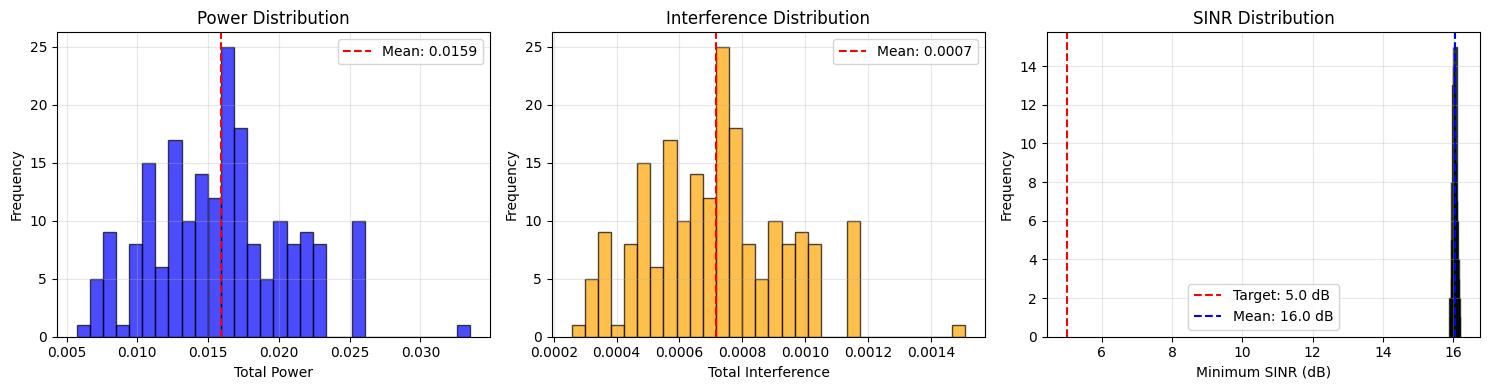


✅ Complete! Plot saved to ./ppo_models/results.png


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Power distribution
axes[0].hist(powers, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(powers.mean(), color='red', linestyle='--',
                label=f'Mean: {powers.mean():.4f}')
axes[0].set_xlabel('Total Power')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Power Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Interference distribution
axes[1].hist(interfs, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(interfs.mean(), color='red', linestyle='--',
                label=f'Mean: {interfs.mean():.4f}')
axes[1].set_xlabel('Total Interference')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Interference Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

# SINR distribution
axes[2].hist(sinr_mins, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[2].axvline(SINR_TARGET_DB, color='red', linestyle='--',
                label=f'Target: {SINR_TARGET_DB} dB')
axes[2].axvline(sinr_mins.mean(), color='blue', linestyle='--',
                label=f'Mean: {sinr_mins.mean():.1f} dB')
axes[2].set_xlabel('Minimum SINR (dB)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('SINR Distribution')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, 'results.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nComplete! Plot saved to {SAVE_PATH}/results.png")

In [ ]:
def predict_power(model, env, feature_dict):
    """Quick prediction for new scenario"""
    # Create feature vector
    obs = np.array([feature_dict.get(f, 0.0) for f in feature_columns], dtype=np.float32)
    obs = obs.reshape(1, -1)

    # Normalize (if using VecNormalize)
    obs_norm = env.normalize_obs(obs)

    # Predict
    action, _ = model.predict(obs_norm, deterministic=True)
    powers = action[0] * P_user_max

    return powers

# Example usage
print("\n" + "="*70)
print("EXAMPLE PREDICTION")
print("="*70)

example = {
    'avg_uplink': 2.3,
    'avg_crosslink': 0.05,
    'avg_uplink_interference': 0.02,
    'UL_ISR': 0.01,
    'scenario_encoded': 2
}

try:
    predicted_powers = predict_power(best_model, train_env, example)
    print(f"Predicted powers for {N_USERS} users:")
    for i, p in enumerate(predicted_powers):
        print(f"  User {i+1}: {p:.6f} W")
    print(f"Total power: {predicted_powers.sum():.6f} W")
except Exception as e:
    print(f"Note: Prediction example requires matching features. Error: {e}")



EXAMPLE PREDICTION
Predicted powers for 10 users:
  User 1: 0.013227 W
  User 2: 0.012485 W
  User 3: 0.011635 W
  User 4: 0.011986 W
  User 5: 0.012420 W
  User 6: 0.011420 W
  User 7: 0.010524 W
  User 8: 0.011340 W
  User 9: 0.011915 W
  User 10: 0.011677 W
Total power: 0.118628 W

✅ All done!
